The goal here is to understand the properties of behavioural data and to compare the participants' responses to the responses of simulated agents with planning depth fixed at various levels.

In [67]:
# -*- coding: utf-8 -*-

#%matplotlib inline
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

from os import listdir, name, sep
import pandas as pd

import sys
sys.path.append('../')

In [68]:
from os.path import expanduser

def load_and_format_data(relative_path, cutoff=0):
    home = expanduser("~")

    path = home + relative_path  # change to correct path
    fnames = np.sort(listdir(path))

    # define order and trial parameters
    T = 100
    n_subs = len(fnames)
    order = np.tile(range(1,5), (25,1)).flatten(order = 'F')
    mini_blocks = np.arange(1, T + 1)

    # inititate data frame
    data = pd.DataFrame(columns = ['gain', 
                                   'start_points', 
                                   'log_rt_1', 
                                   'log_rt_sum', 
                                   'subject', 
                                   'block_number', 
                                   'phase', 
                                   'order',
                                   'block_index',
                                   'end_points'])

    states = []
    responses = []
    
    subject = 0
    valid = np.ones(len(fnames)).astype(bool)
    for i,f in enumerate(fnames):
        parts = f.split('_')
        tmp = io.loadmat(path+f)
        points = tmp['data']['Points'][0, 0]

        # get response times
        rts = np.nan_to_num(tmp['data']['Responses'][0,0]['RT'][0,0])

        # get number of trials in each mini-block
        notrials = tmp['data']['Conditions'][0,0]['notrials'][0,0].flatten()

        # get points at the last trial of the miniblock
        end_points = points[range(100), (np.nan_to_num(notrials)-1).astype(int)]
        
        if end_points[-1] > cutoff:
            subject += 1
            states.append(tmp['data']['States'][0,0] - 1)
            responses.append(tmp['data']['Responses'][0,0]['Keys'][0,0] - 1)

            start_points = 1000
            df = pd.DataFrame()

            df['gain']= np.diff(np.hstack([start_points, end_points]))

            df['start_points'] = np.hstack([start_points, end_points])[:-1]
            df['end_points'] = end_points

            # define log_rt as the natural logarithm of the sum of response times over all trials
            df['log_rt_1']= np.log(rts[:, 0])
            df['log_rt_sum'] = np.log(np.nansum(rts, -1))

            df['subject'] = subject
            df['ID'] = parts[1]
            df['block_number'] = mini_blocks

            if notrials[0] == 3:
                df['phase'] = np.hstack([order[50:], order[:50]])
                df['order'] = 2
                df['block_index'] = np.hstack([mini_blocks[50:], mini_blocks[:50]])

            else:
                df['phase'] = order
                df['order'] = 1
                df['block_index'] = mini_blocks

            data = data.append(df, ignore_index=True, sort=False)
        else:
            valid[i] = False
    
    print('fraction of excluded participants ', 1. - subject/len(fnames))
    return data, states, responses, valid

In [69]:
### load behavioural data ###

path1 = '/Dropbox/Johannes/_Dokumente_UNI_CAN/KURSE/MASTER_THESIS/MA_Prof_Smolka/data/OldAdults/space_adventure/Experiment/'  # change to correct path
path2 = '/Dropbox/Johannes/_Dokumente_UNI_CAN/KURSE/MASTER_THESIS/MA_Prof_Smolka/data/YoungAdults/space_adventure/Experiment/'

data_old, states_old, responses_old, valid_old = load_and_format_data(path1, cutoff=0)
data_young, states_young, responses_young, valid_young = load_and_format_data(path2, cutoff=0)

data_old['group'] = 'OA'
data_young['group'] = 'YA'

# add mean planning depths (merge on subject ID and block_index)
df = pd.read_excel('/home/johannes/Dropbox/Johannes/_Dokumente_UNI_CAN/KURSE/MASTER_THESIS/MA_Prof_Smolka/data/SAT_singleMiniblocks.xlsx', dtype={'Subject_ID':object})
df = df.rename(columns={"Subject_ID":"ID", "Block_id":"block_index"})
data_old = pd.merge(left = data_old, right = df[df.group==1][["ID","MeanPD","block_index"]], on=["ID","block_index"], how="left")
data_young = pd.merge(left = data_young, right = df[df.group==0][["ID","MeanPD","block_index"]], on=["ID","block_index"], how="left")

data = data_old.append(data_young, ignore_index=True)


fraction of excluded participants  0.0
fraction of excluded participants  0.0


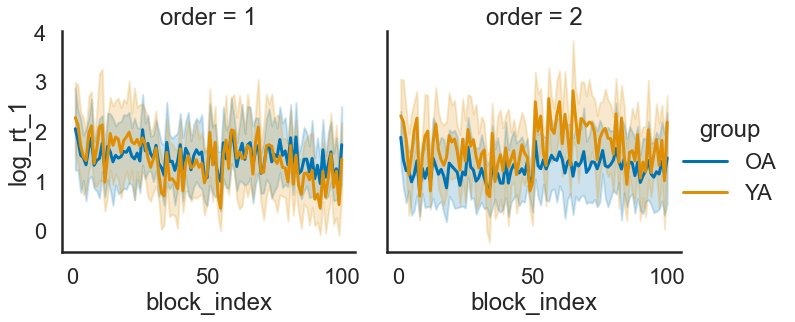

In [70]:
# plot mean of the log(rt_1) with 95% confidence interval or standard deviation
g = sns.FacetGrid(data, col="order", hue='group', height=5)
g = (g.map(sns.lineplot, "block_index", "log_rt_1", ci="sd").add_legend());

In the plots above order = 1 denotes the experimental sequence in which participants start with 2 trial mini-blocks, and after 50 mini-blocks switch to 3 trial mini-blocks. Order = 2 denotes the reversered order in which participants start with 3 trial mini-blocks. The block index denotes the phase dependent index of a mini-block, where in order 1 condition we are counting blocks from 1 to 100, and in order 2 condition from 
50 to 100, and from 1 to 50. Hence, the above plots are aligned with respect to their condition.

To determine quantities which most influence response times we will perform a linear regression with respect to following predictor variables:
- logarithm of mini-block number 
- phase of the experiment 
- number of points at the beggining of the mini-block
- mean inferred pleanning depth of miniblock

In [76]:
#%% plot design matrix X
from matplotlib import colors

def plot_design_matrix(matrix, name = "Design Matrix", footnote = ""):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1)
    #ax.set_aspect('equal')
    ax.set_title(name)
    divnorm = colors.TwoSlopeNorm(vcenter=0)                    
    plt.imshow(matrix, aspect='auto', cmap=plt.cm.ocean, norm=divnorm)
    ax.set_ylabel("miniblock")
    ax.set_xlabel("predictor")
    plt.colorbar()
    plt.figtext(0.5, 0.01, footnote, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.show()
    

In [72]:
#%%
from bayesian_linear_regression import BayesLinRegress

T = 100

def sample_posterior(data, states, responses):
    n_subs = len(np.unique(data.subject))
    y1 = data['log_rt_1'].values.reshape(n_subs, T).T
    
    models = []
    
    ######## predictors #########
    # All non-constant predictors are standardized according to Gelman 2007: mean zero, sd 1/2
    
    # predictor0: single intercept
    intercept = np.ones((T, n_subs, 1))
    
    # predictor1-4: phase indicators
    phases = data.phase.values.astype(int).reshape(n_subs, T).T - 1
    phase_indis = np.eye(4)[phases]
    
    # predictor5: steps indicator
    steps_indis = np.expand_dims(np.bitwise_or(phase_indis[:,:,2].astype(int), phase_indis[:,:,3].astype(int)), -1)
    
    # predictor6: noise indicator
    noise_indis = np.expand_dims(np.bitwise_or(phase_indis[:,:,1].astype(int), phase_indis[:,:,3].astype(int)), -1)
    
    # predictor7: log(miniblock number)
    log_mb_nr = np.log(np.expand_dims(data['block_number'].values.astype(int).reshape(n_subs, T).T, -1)) 
    log_mb_nr -= log_mb_nr.mean(0)
    log_mb_nr /= (2 * log_mb_nr.std(0)) 
          
    # predictor8: starting points of miniblock
    start_points = np.expand_dims(data.start_points.values.copy().reshape(n_subs, T).T, -1)
    start_points -= start_points.mean(0)
    start_points /= 2*start_points.std(0)

    # predictor9: planning depth
    meanpd = np.expand_dims(data.MeanPD.values.copy().reshape(n_subs, T).T, -1)
    meanpd -= meanpd.mean(0)
    meanpd /= 2 * meanpd.std(0)
    
    X = np.concatenate([phase_indis, noise_indis, steps_indis, log_mb_nr, start_points, meanpd], -1)
    pred_labels = ['intercept', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'noise_indis', 'steps_indis', 'log_mb_nr', 'start_points', 'mean_pd']
    
    # calc pearson r for predictors and plot their distribution over subjects
    X_corrcoefs = np.expand_dims(np.corrcoef(X[:,0,:], rowvar = False), -1)
    for i in range(1, n_subs):
        X_corrcoefs = np.concatenate([X_corrcoefs, np.expand_dims(np.corrcoef(X[:,i,:], rowvar = False), -1)], -1)
    pars = X_corrcoefs.shape[0]
    fig = plt.figure(figsize=(25, 15))
    fig.suptitle("dist of pearson r over subs")
    rs = [] # pearson r coefficients
    ls = [] # labels of correlated vars
    for i in range(pars):
        for j in range(7, pars):    # 7 to skip indicator correlations 
            if (j>i):
                rs.append(X_corrcoefs[i,j,:])
                ls.append(pred_labels[i+1] + ' ~ ' + pred_labels[j+1]) # +1 to skip intercept label
    plt.boxplot(rs, vert=0)
    ax = plt.axes()
    ax.set_yticklabels(ls)
    plt.tight_layout()
    plt.show()
    
    
    ######## model 1 #########
    description = 'log(RT_first_action) = b0 + b1 * log(miniblock_nr) + b2 * starting_points'
    X = np.concatenate([intercept, log_mb_nr, start_points], -1)
    plot_design_matrix(X[:,0,:],'Model 1',description)  # plot design matrix of first subject
    m1 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m1)

    
    ######### model 2 #########
    description = 'log(RT_first_action) = b0 + b1 * log(miniblock_nr) + b2 * starting_points + b3 * mean_PD'
    X = np.concatenate([X, meanpd], -1)   
    plot_design_matrix(X[:,0,:],'Model 2',description)  # plot design matrix of first subject
    m2 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m2)
    
   
    ######### model 3 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * log(miniblock_nr) + b5 * starting_points'
    X = np.concatenate([phase_indis, log_mb_nr, start_points], -1)         
    plot_design_matrix(X[:,0,:],'Model 3',description)  # plot design matrix of first subject
    m3 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m3)      


    ######### model 4 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * log(miniblock_nr) + b5 * starting_points + b6 * mean_PD'
    X = np.concatenate([X, meanpd], -1) 
    plot_design_matrix(X[:,0,:],'Model 4',description)  # plot design matrix of first subject
    m4 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m4)
    
    
    ######### model 5 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4'
    X = phase_indis
    plot_design_matrix(X[:,0,:],'Model 5',description)  # plot design matrix of first subject
    m5 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m5)
    
    
    ######### model 6 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * log(miniblock_nr)'
    X = np.concatenate([phase_indis, log_mb_nr], -1)         
    plot_design_matrix(X[:,0,:],'Model 6',description)  # plot design matrix of first subject
    m6 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m6)
    
    
    ######### model 7 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * starting_points'
    X = np.concatenate([phase_indis, start_points], -1)         
    plot_design_matrix(X[:,0,:],'Model 7',description)  # plot design matrix of first subject
    m7 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m7)  
    
    
    ######### model 8 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * meanPD'
    X = np.concatenate([phase_indis, meanpd], -1)         
    plot_design_matrix(X[:,0,:],'Model 8',description)  # plot design matrix of first subject
    m8 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m8) 
    
    
    ######### model 9 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * starting_points + b5 * meanPD'
    X = np.concatenate([phase_indis, start_points, meanpd], -1)         
    plot_design_matrix(X[:,0,:],'Model 9',description)  # plot design matrix of first subject
    m9 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m9)      
    
    
    ######### model 10 #########
    description = 'log(RT_first_action) = b0-3 * phase1-4 + b4 * log_mb_nr + b5 * meanPD '
    X = np.concatenate([phase_indis, log_mb_nr, meanpd], -1)         
    plot_design_matrix(X[:,0,:],'Model 10',description)  # plot design matrix of first subject
    m10 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m10)     
        

    samples = []
    waic = []
    for m in models:
          samples.append(m.fit(num_samples=1000, warmup_steps=5000, summary=False))
          waic.append(m.waic())
          print('model waic', waic[-1])
        
    return samples, waic

/home/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


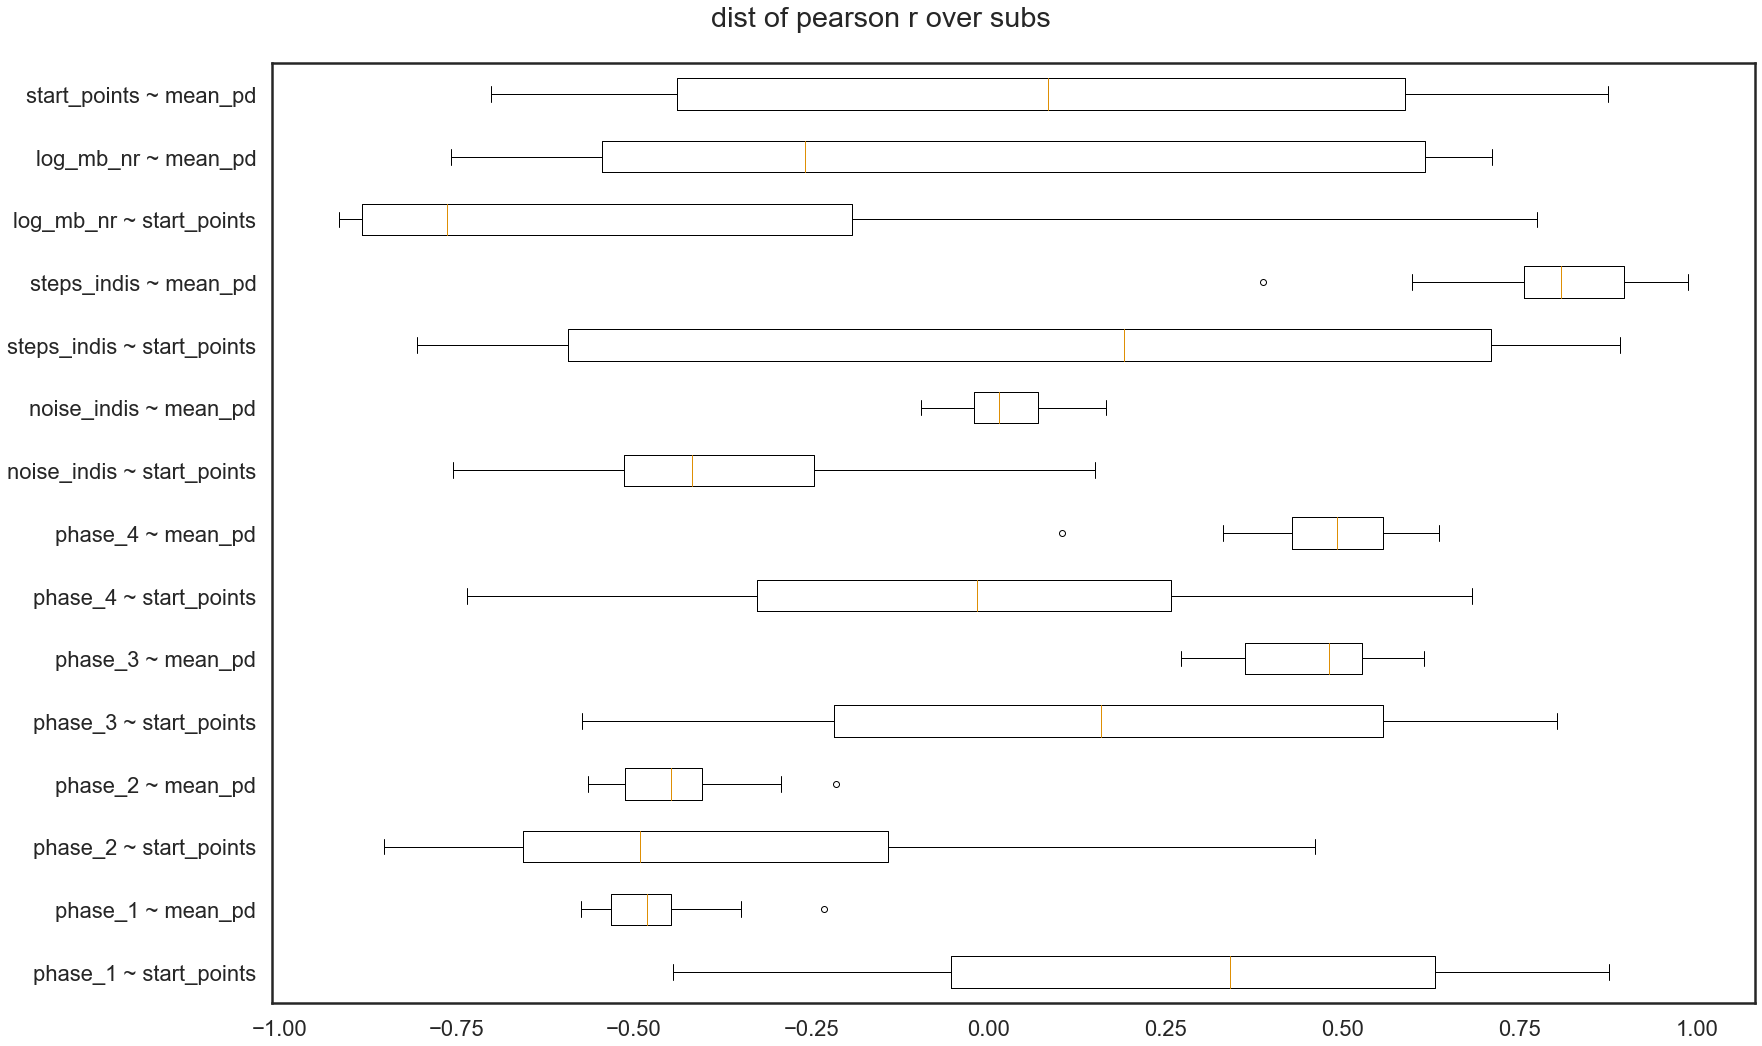

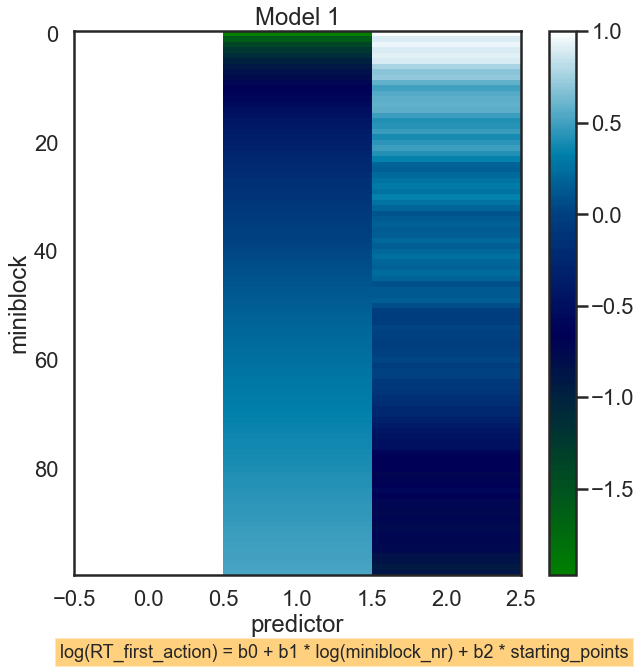

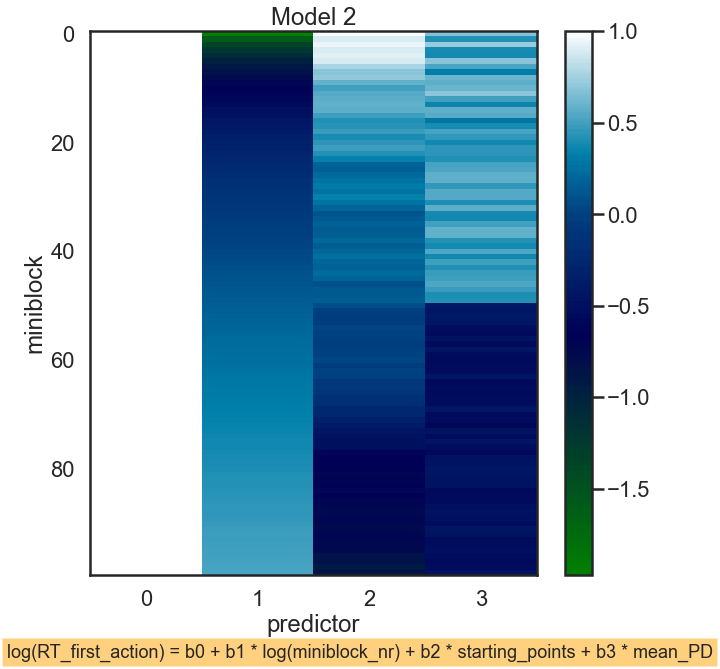

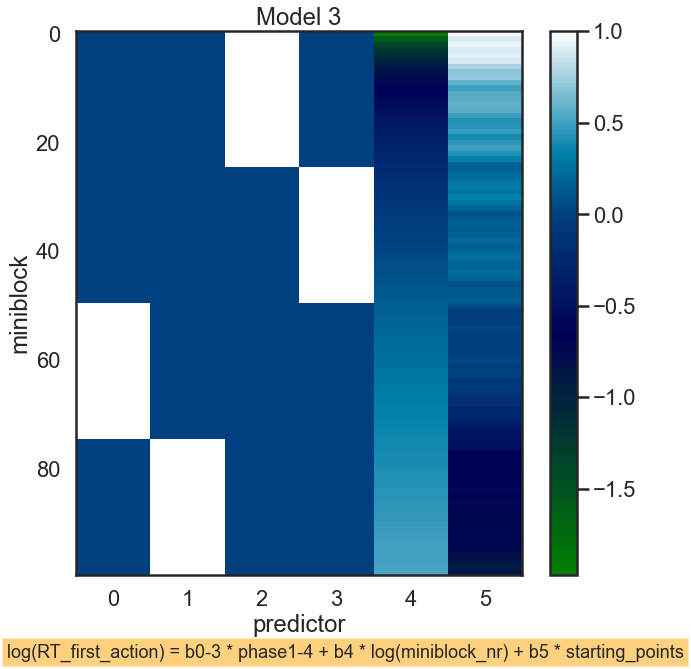

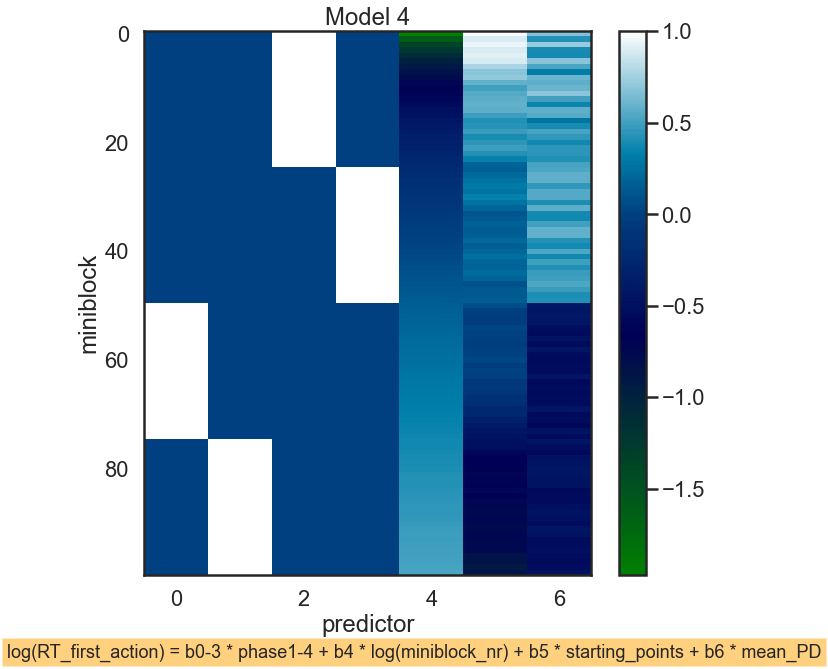

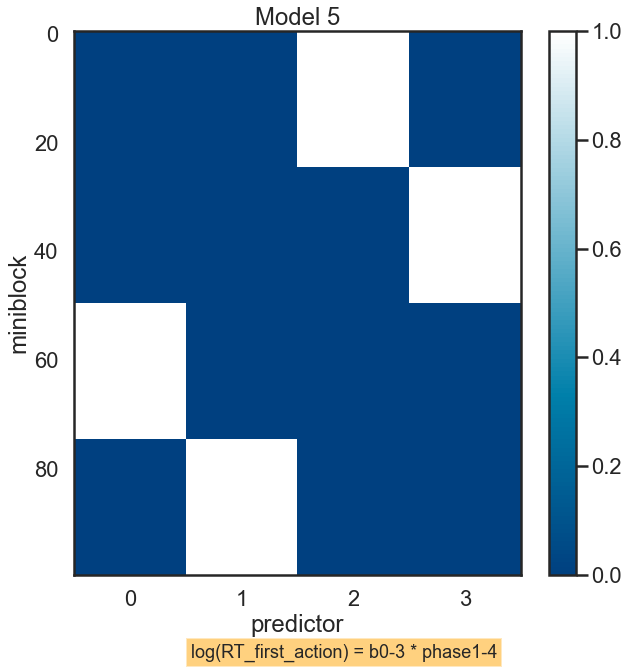

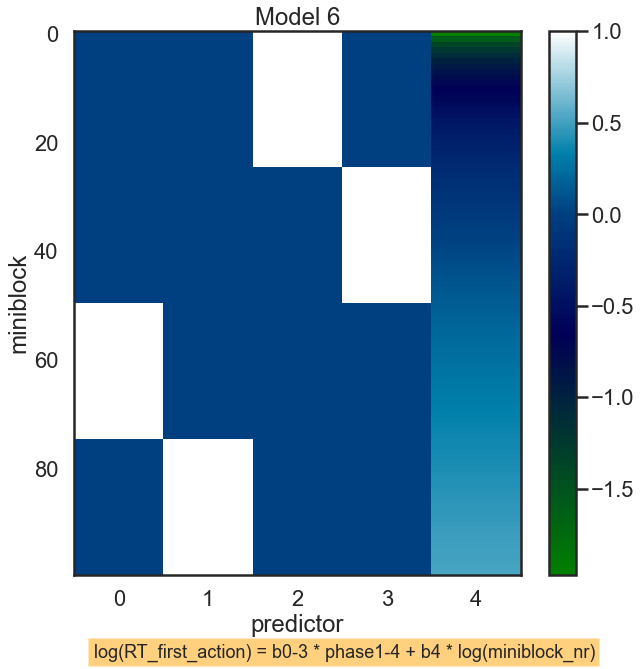

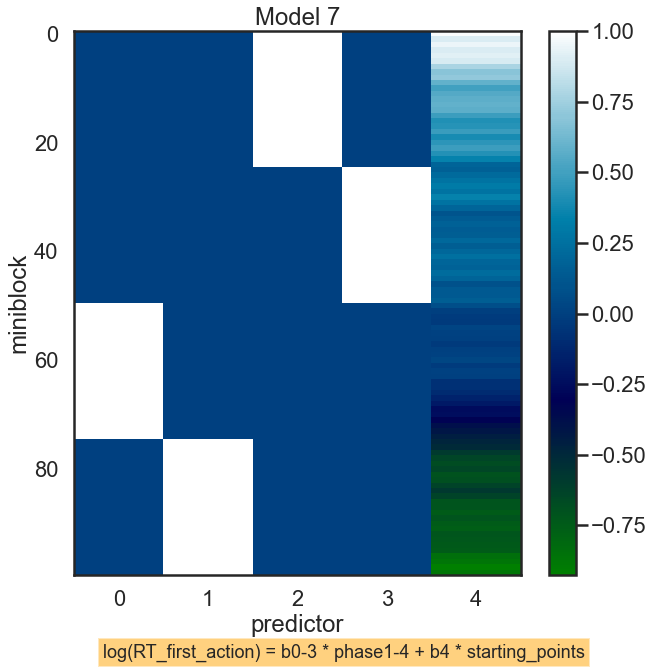

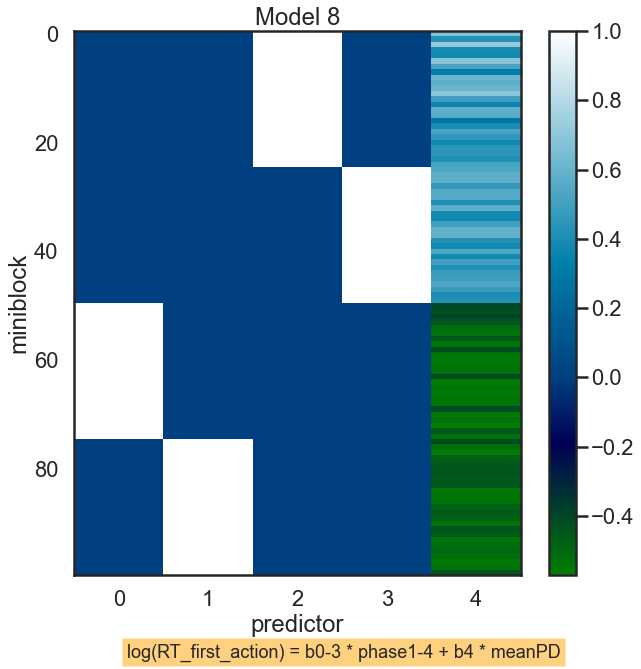

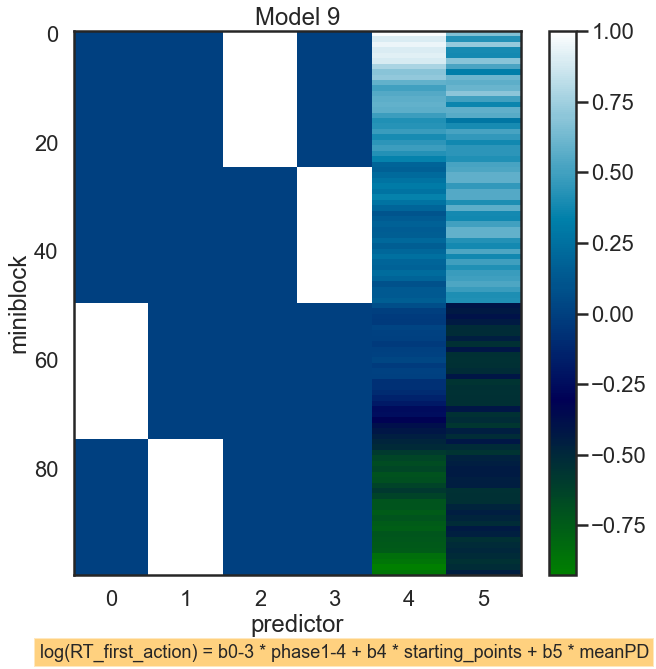

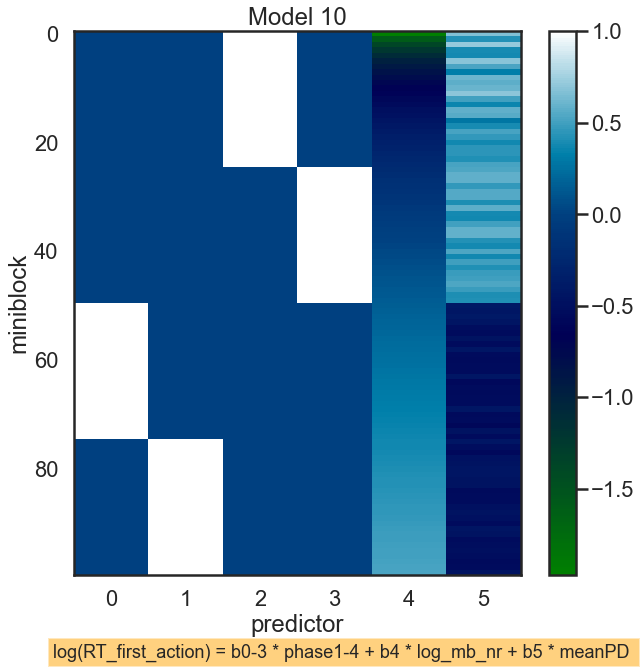

  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1631.6008


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1632.814


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1639.7172


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1642.6028


sample: 100%|██████████| 6000/6000 [02:05<00:00, 47.99it/s, 511 steps of size 9.85e-03. acc. prob=0.90] 


model waic -1651.6375


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1639.56


sample: 100%|██████████| 6000/6000 [02:08<00:00, 46.61it/s, 511 steps of size 1.01e-02. acc. prob=0.87] 


model waic -1644.2727


sample: 100%|██████████| 6000/6000 [02:15<00:00, 44.16it/s, 511 steps of size 9.34e-03. acc. prob=0.90] 


model waic -1652.7587


sample: 100%|██████████| 6000/6000 [02:35<00:00, 38.52it/s, 511 steps of size 1.05e-02. acc. prob=0.83] 


model waic -1647.4349


sample: 100%|██████████| 6000/6000 [02:38<00:00, 37.87it/s, 511 steps of size 7.85e-03. acc. prob=0.93] 


model waic -1644.7732


In [78]:
samples_old, waic_old = sample_posterior(data_old, states_old, responses_old)

/home/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


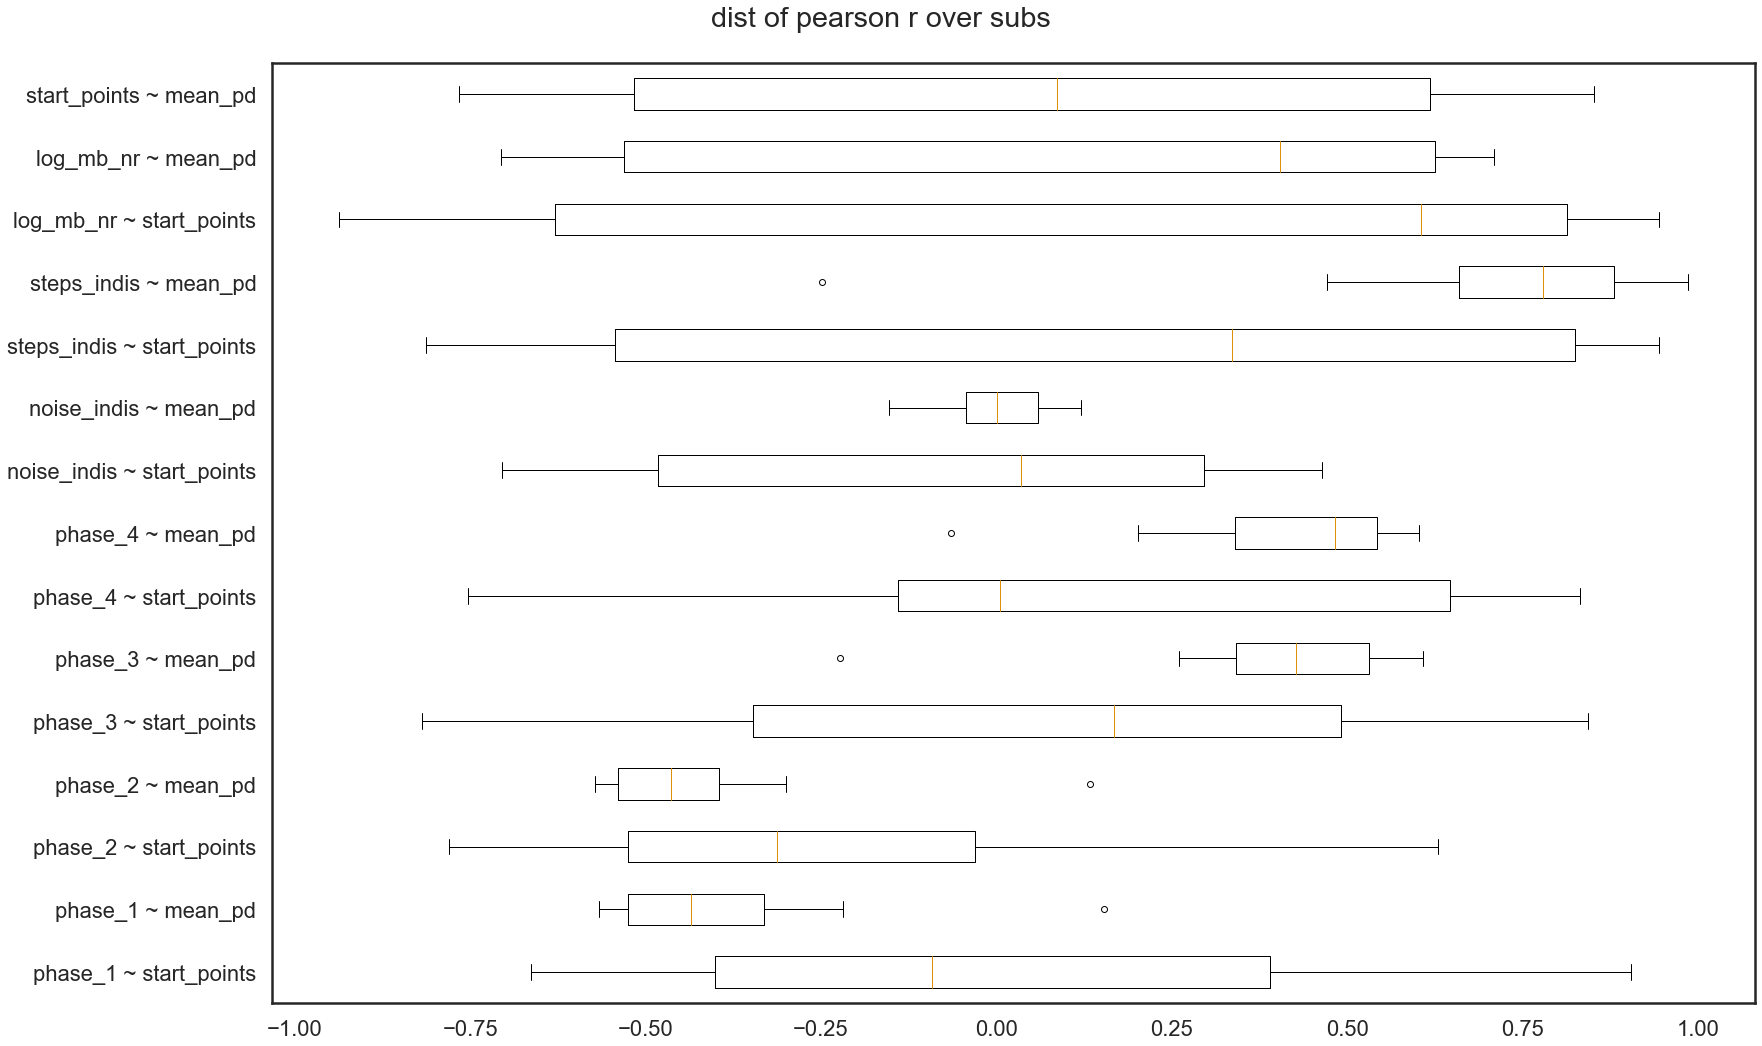

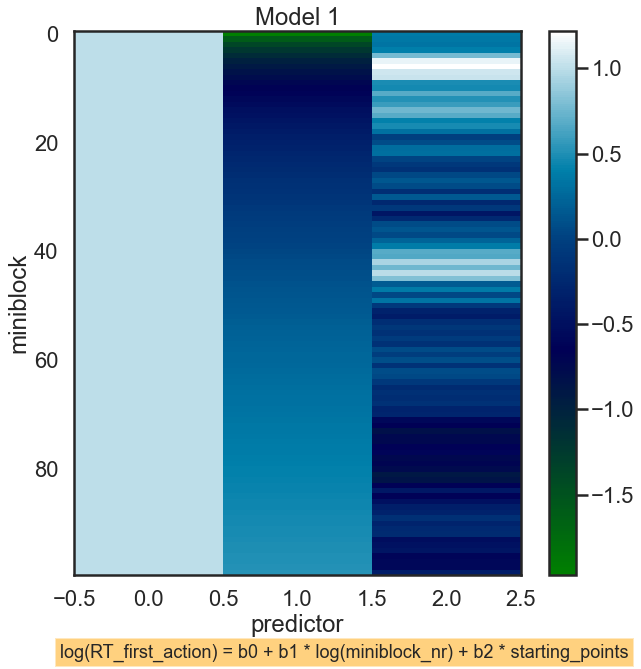

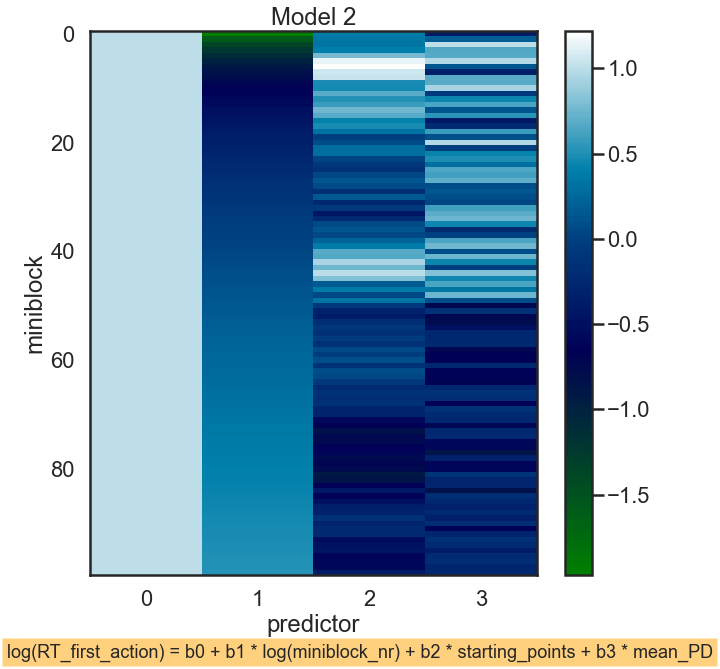

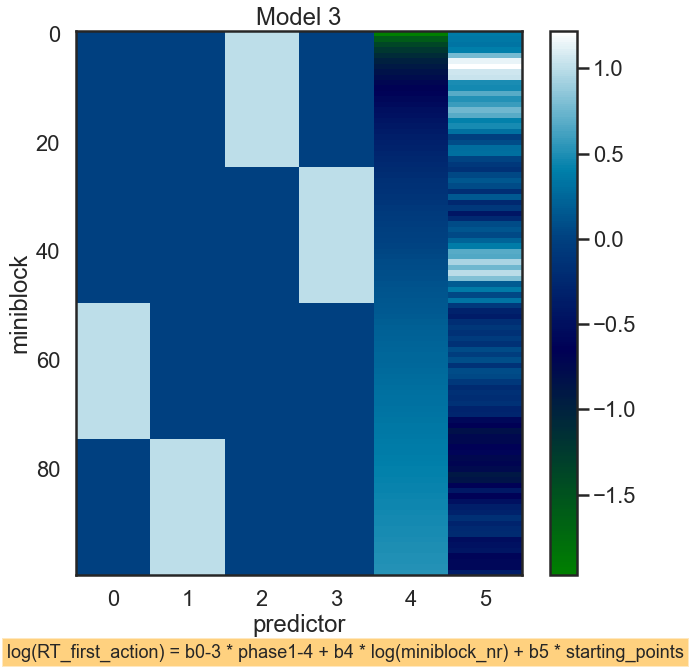

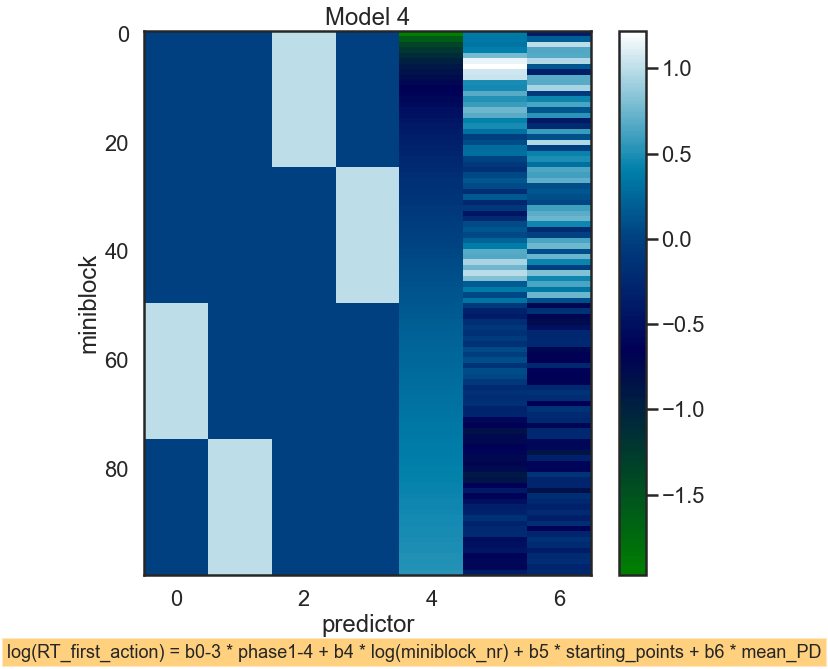

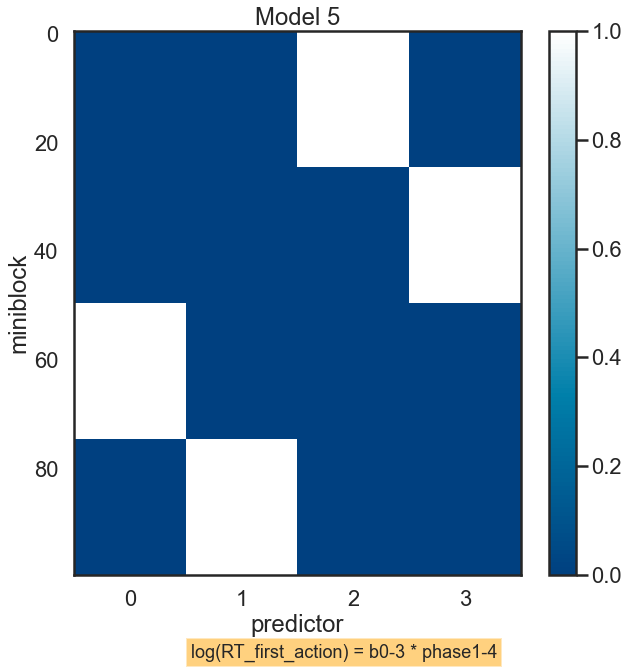

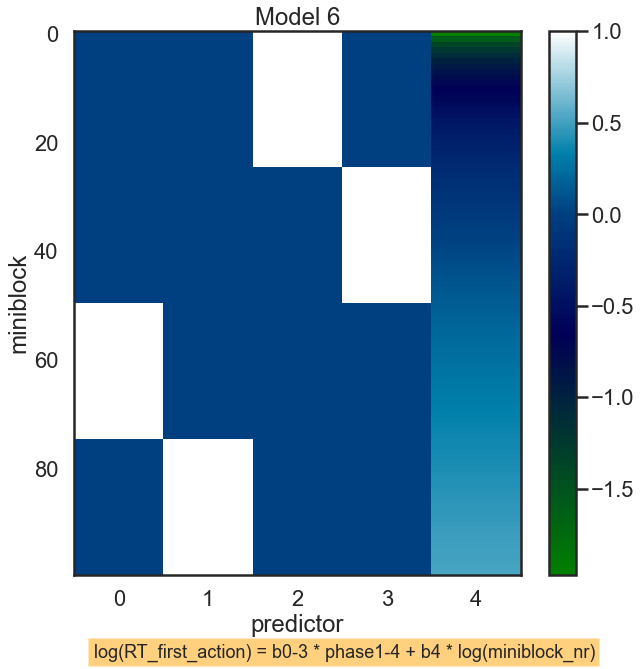

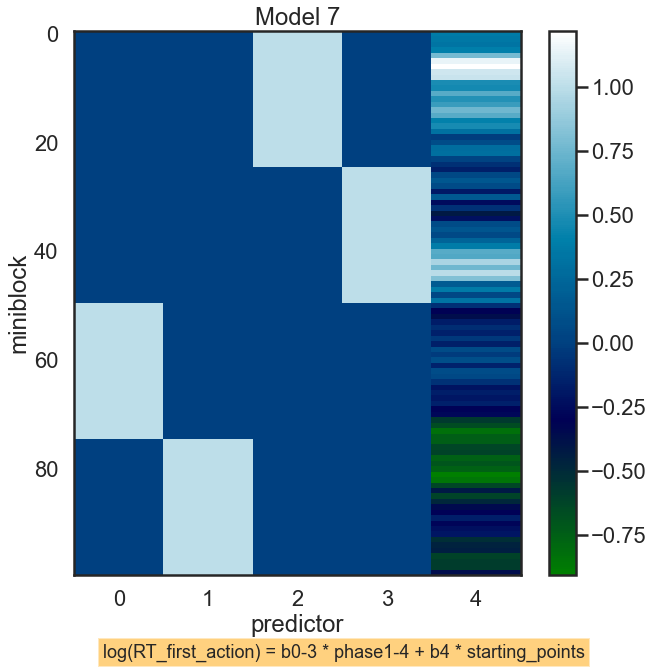

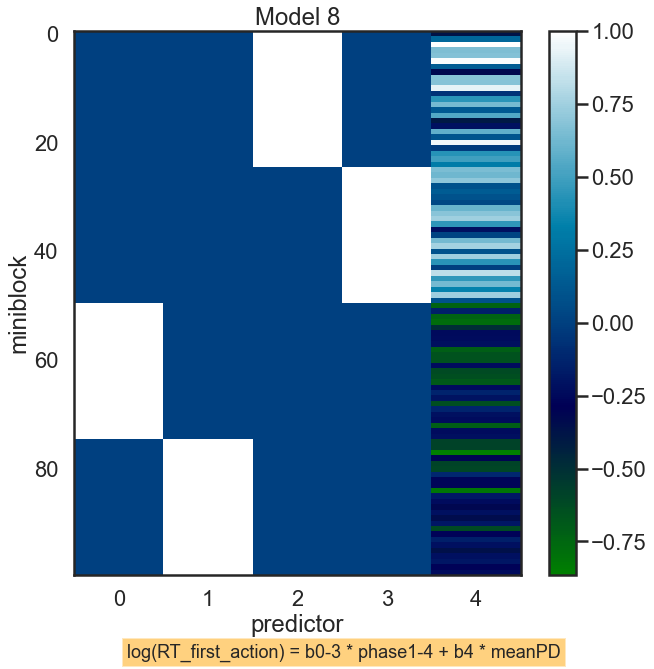

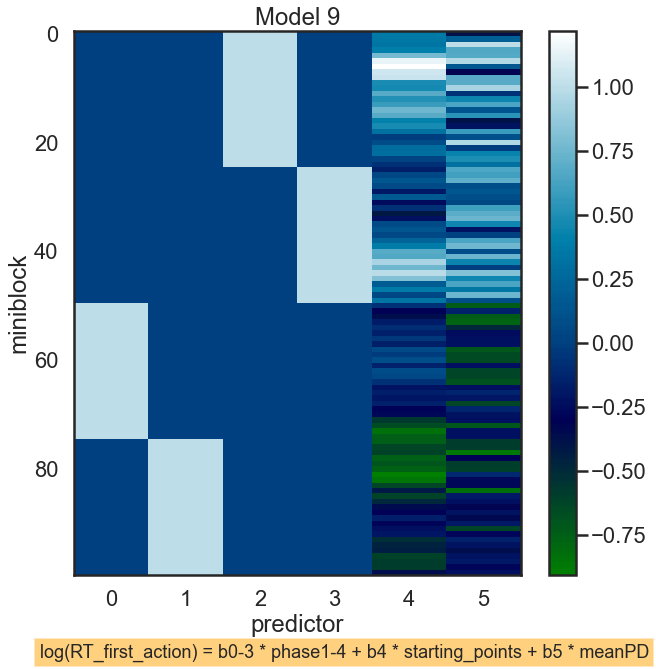

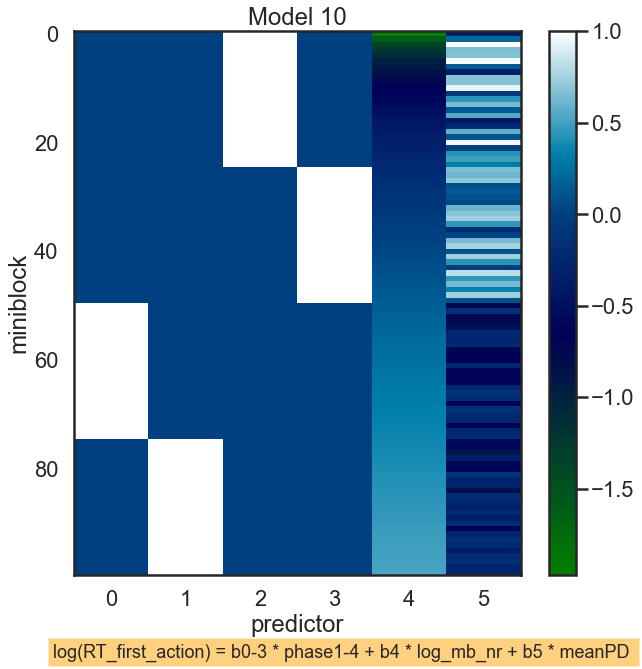

  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2448.1387


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2451.3396


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2394.115


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2390.2126


sample: 100%|██████████| 6000/6000 [01:20<00:00, 74.77it/s, 255 steps of size 1.34e-02. acc. prob=0.90] 


model waic -2394.1587


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2390.507


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2400.2297


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2388.237


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2390.917


sample: 100%|██████████| 6000/6000 [01:52<00:00, 53.48it/s, 511 steps of size 1.18e-02. acc. prob=0.92] 


model waic -2386.803


In [77]:
samples_young, waic_young = sample_posterior(data_young, states_young, responses_young)

Bellow we visualise the results of linear regression for young and old adults

In [79]:
### visualise regression results ###

import numpy as onp

model_nr = len(samples_old)

betas = {'old': [], 'young': []}
for smpl1, smpl2 in zip(samples_old, samples_young):
    betas['old'].append(onp.array(smpl1['beta']).astype(onp.double))
    betas['young'].append(onp.array(smpl2['beta']).astype(onp.double))
    

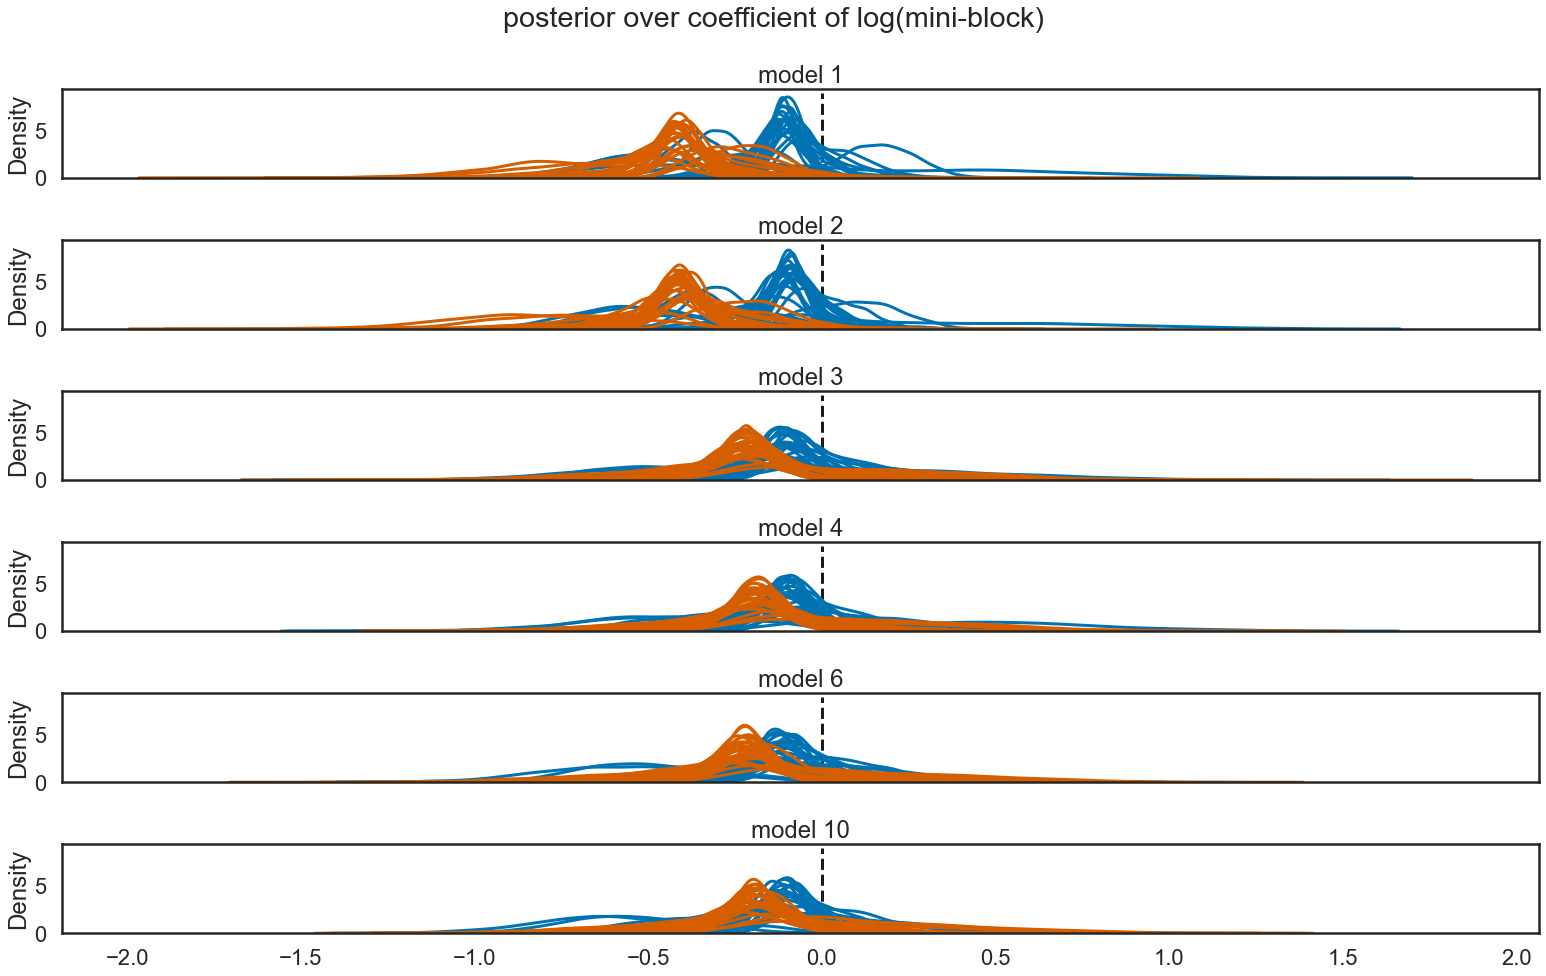

In [95]:
fig, ax = plt.subplots(6, 1, sharex = True, figsize=(22, 14))

color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][0][:, i, 1], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][1][:, i, 1], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)
        sns.kdeplot(betas[group][2][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[2], legend=False)
        sns.kdeplot(betas[group][3][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[3], legend=False)
        sns.kdeplot(betas[group][5][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[4], legend=False)
        sns.kdeplot(betas[group][9][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[5], legend=False)

fig.suptitle('posterior over coefficient of log(mini-block)');
for i in range(ax.size):
    ax[i].vlines(0, 0, 9, 'k', linestyle='--');
    #ax[i].xaxis.set_tick_params(which='both', labelbottom=True)

ax[0].set_title('model 1')
ax[1].set_title('model 2')
ax[2].set_title('model 3')
ax[3].set_title('model 4')
ax[4].set_title('model 6')
ax[5].set_title('model 10')
plt.tight_layout()

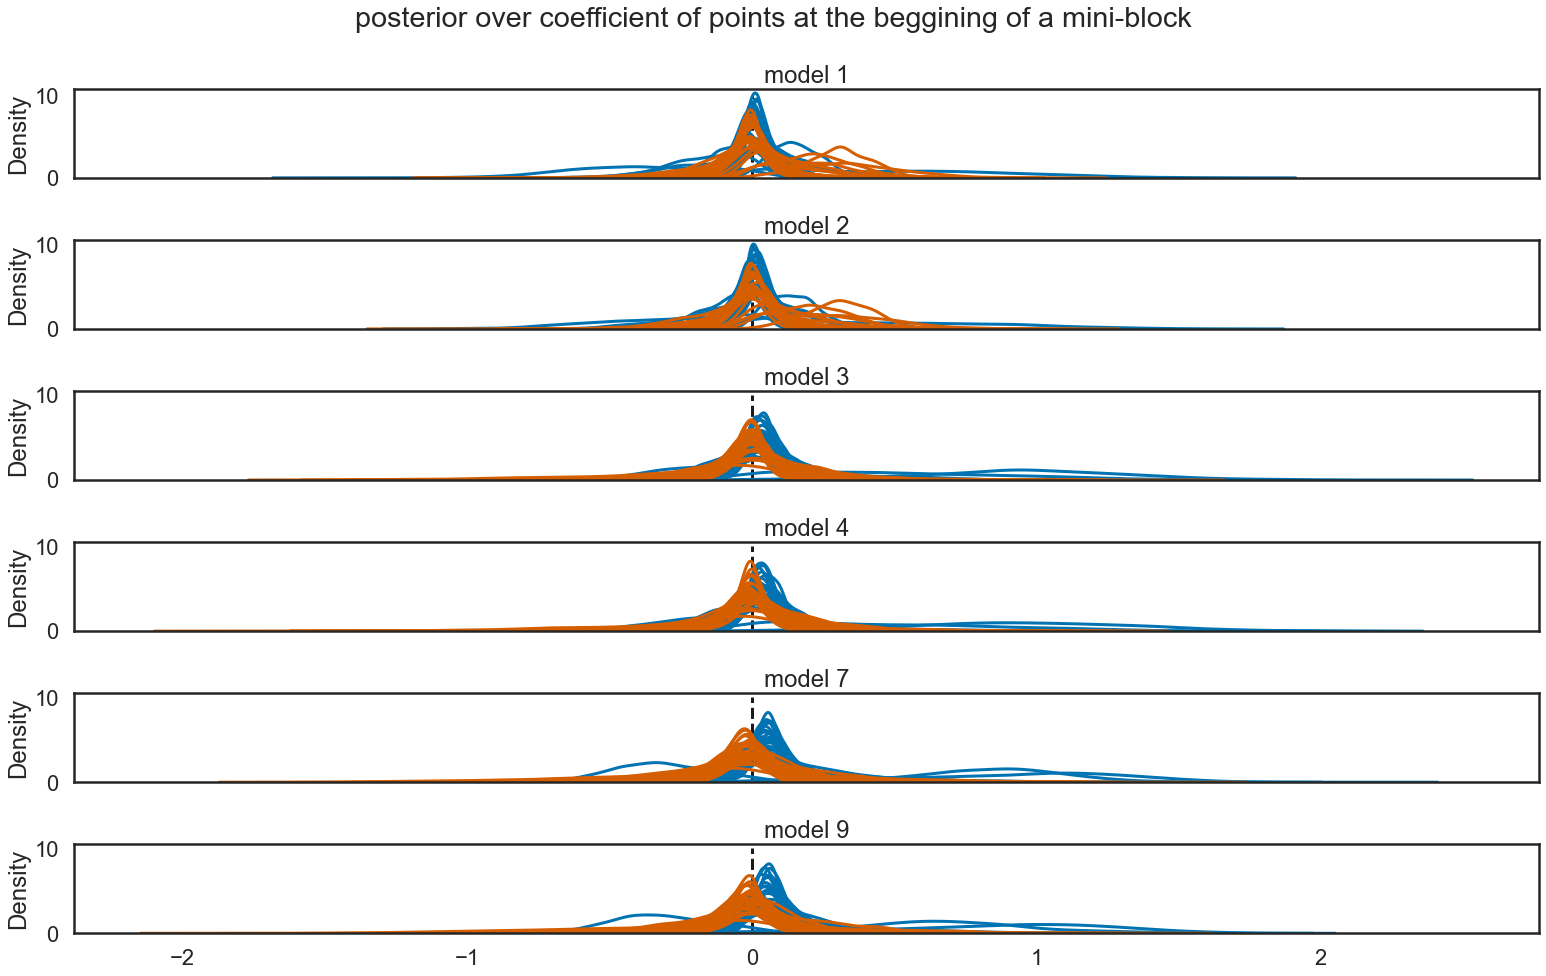

In [82]:
fig, ax = plt.subplots(6, 1, sharex = True, figsize=(22, 14))
color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][0][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][1][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)
        sns.kdeplot(betas[group][2][:, i, 5], color=color[group], alpha=.5, label=i+1, ax=ax[2], legend=False)
        sns.kdeplot(betas[group][3][:, i, 5], color=color[group], alpha=.5, label=i+1, ax=ax[3], legend=False)
        sns.kdeplot(betas[group][6][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[4], legend=False)
        sns.kdeplot(betas[group][8][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[5], legend=False)

fig.suptitle('posterior over coefficient of points at the beggining of a mini-block');
for i in range(ax.size):
    ax[i].vlines(0, 0, 10, 'k', linestyle='--');
    #ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].set_title('model 1')
ax[1].set_title('model 2')
ax[2].set_title('model 3')
ax[3].set_title('model 4')
ax[4].set_title('model 7')
ax[5].set_title('model 9')
plt.tight_layout()

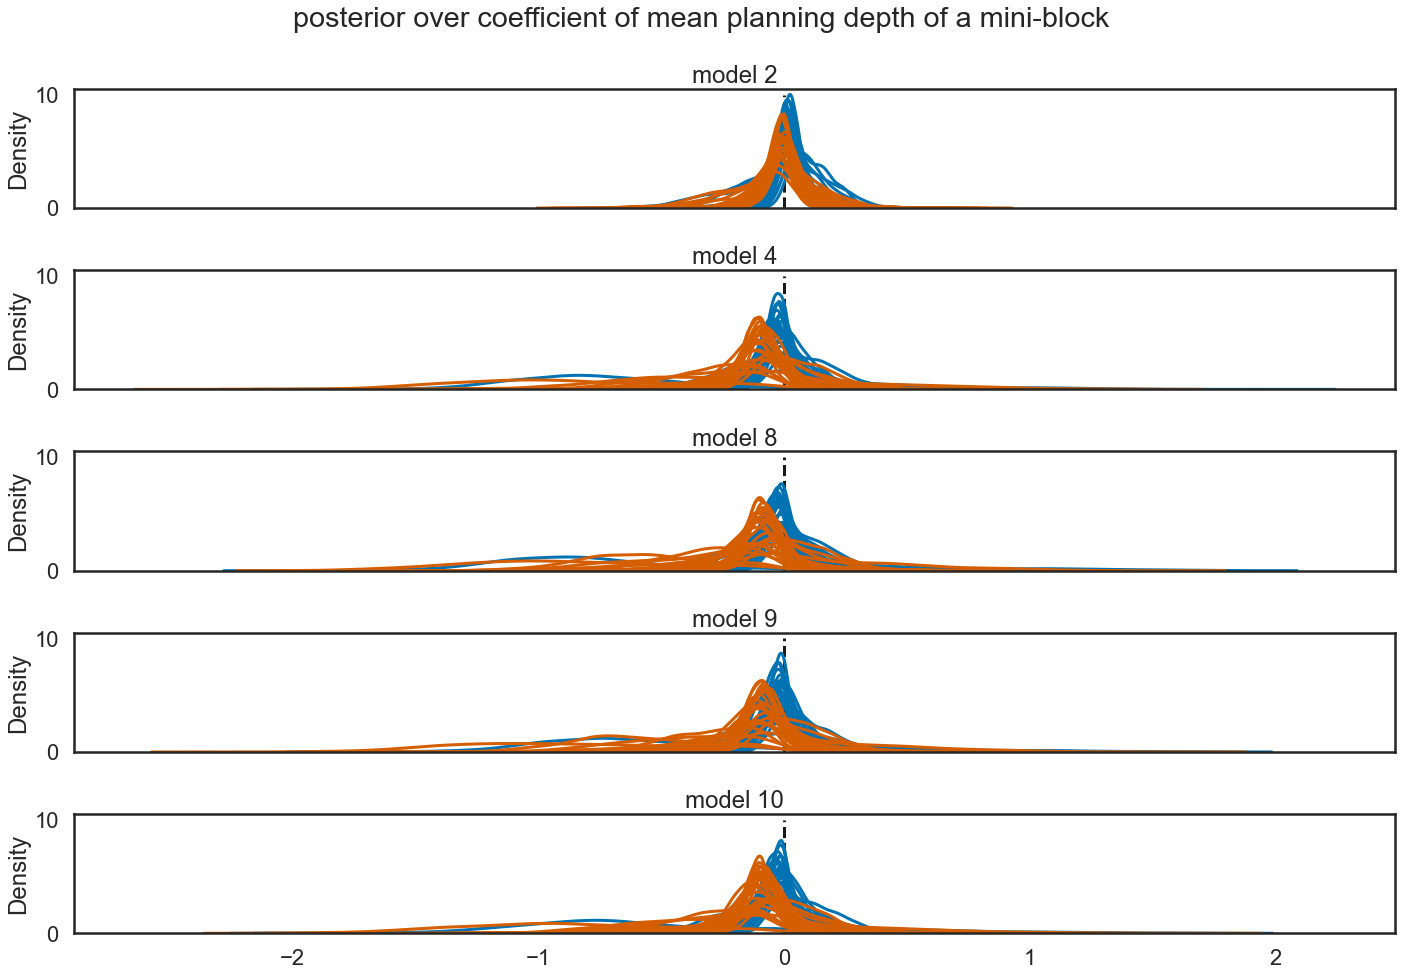

In [86]:
fig, ax = plt.subplots(5, 1, sharex = True, figsize=(20, 14))
color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][1][:, i, 3], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][3][:, i, 6], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)
        sns.kdeplot(betas[group][7][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[2], legend=False)
        sns.kdeplot(betas[group][8][:, i, 5], color=color[group], alpha=.5, label=i+1, ax=ax[3], legend=False)
        sns.kdeplot(betas[group][9][:, i, 5], color=color[group], alpha=.5, label=i+1, ax=ax[4], legend=False)

fig.suptitle('posterior over coefficient of mean planning depth of a mini-block');
for i in range(ax.size):
    ax[i].vlines(0, 0, 10, 'k', linestyle='--');
    #ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].set_title('model 2');
ax[1].set_title('model 4');
ax[2].set_title('model 8');
ax[3].set_title('model 9');
ax[4].set_title('model 10');
plt.tight_layout()

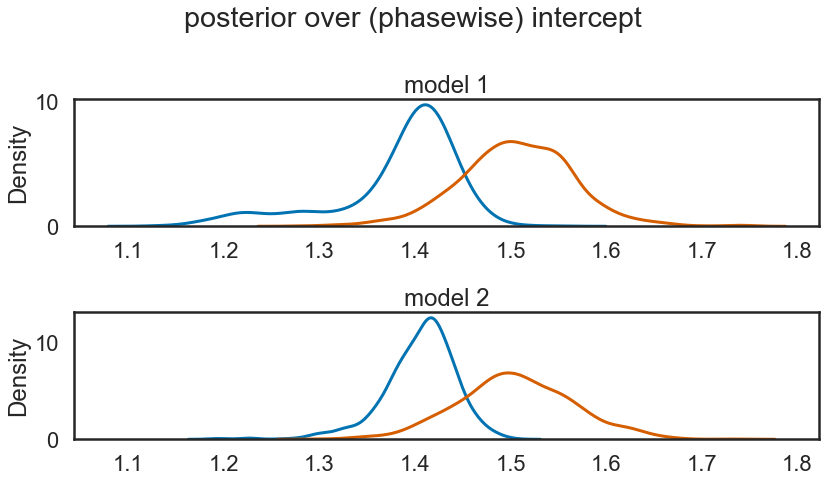

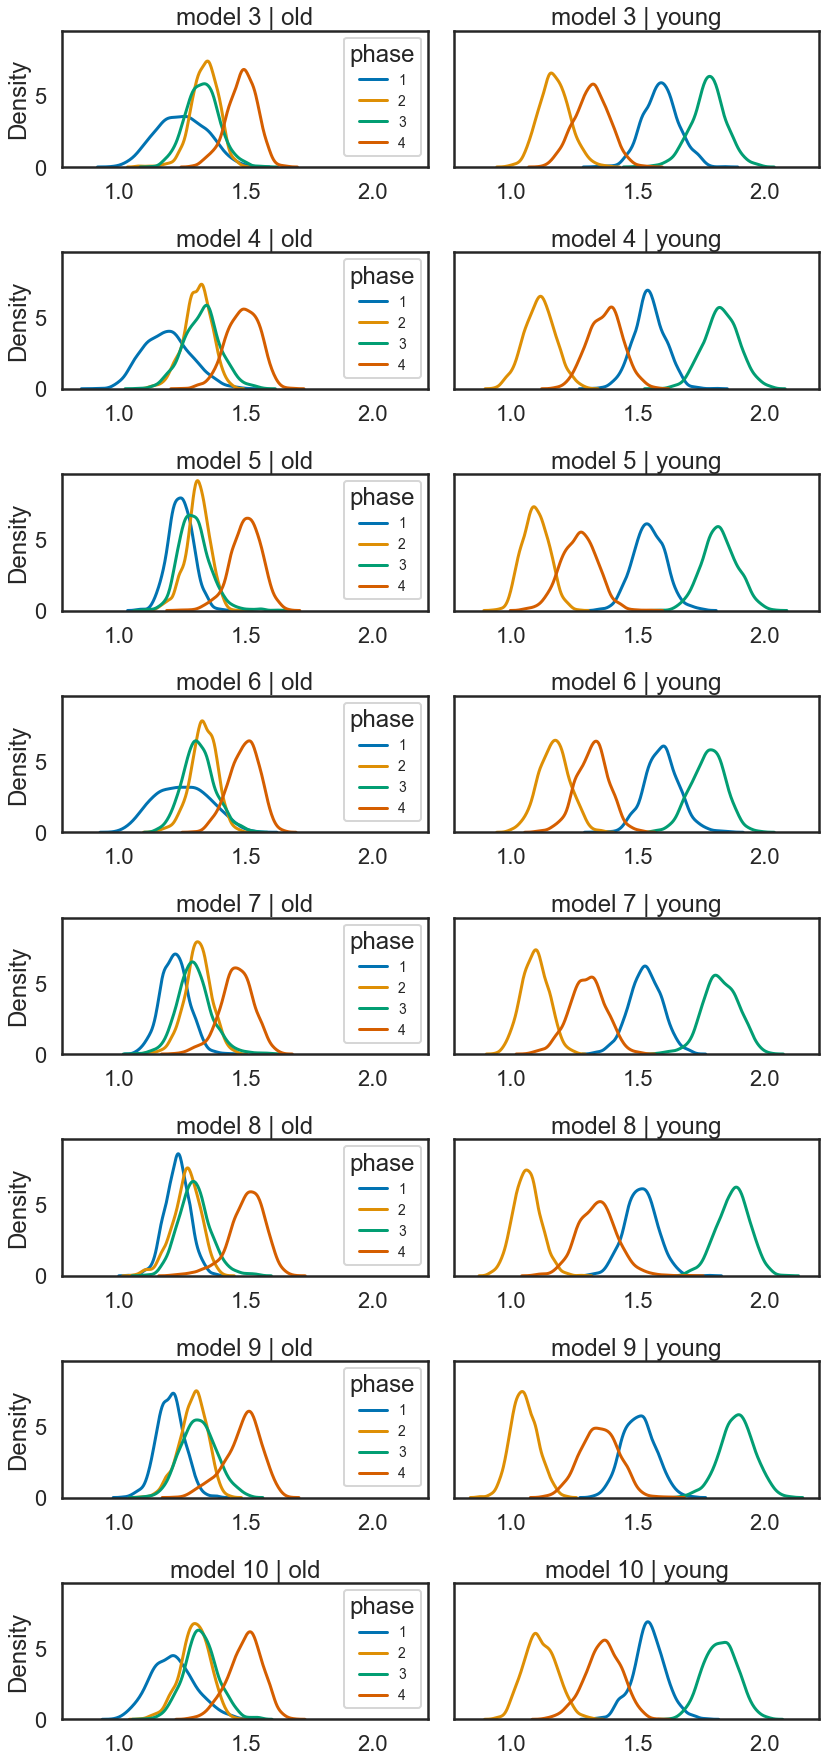

In [97]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(12, 7))
color = {'old': 'b', 'young': 'r'}
colors = ['b','r']

smpl_old = onp.array(samples_old)
smpl_young = onp.array(samples_young)

for i, smpl in enumerate([smpl_old, smpl_young]):
    sns.kdeplot(smpl[0]['group_beta'][:, 0], color=colors[i], alpha=.5, label=i+1, ax=ax[0], legend=False)
    sns.kdeplot(smpl[1]['group_beta'][:, 0], color=colors[i], alpha=.5, label=i+1, ax=ax[1], legend=False)

fig.suptitle('posterior over (phasewise) intercept');
ax[0].set_title('model 1')
ax[1].set_title('model 2')
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()


fig, ax = plt.subplots(8, 2,sharex = True, sharey = True, figsize=(12, 25))
for i, smpl in enumerate([smpl_old, smpl_young]):
    for j in range(4):
        sns.kdeplot(smpl[2]['group_beta'][:, j], label=j+1, ax=ax[0,i], legend=False)
        sns.kdeplot(smpl[3]['group_beta'][:, j], label=j+1, ax=ax[1,i], legend=False)
        sns.kdeplot(smpl[4]['group_beta'][:, j], label=j+1, ax=ax[2,i], legend=False)
        sns.kdeplot(smpl[5]['group_beta'][:, j], label=j+1, ax=ax[3,i], legend=False)
        sns.kdeplot(smpl[6]['group_beta'][:, j], label=j+1, ax=ax[4,i], legend=False)
        sns.kdeplot(smpl[7]['group_beta'][:, j], label=j+1, ax=ax[5,i], legend=False)
        sns.kdeplot(smpl[8]['group_beta'][:, j], label=j+1, ax=ax[6,i], legend=False)
        sns.kdeplot(smpl[9]['group_beta'][:, j], label=j+1, ax=ax[7,i], legend=False)

for i in range(ax.shape[0]):
    ax[i,0].set_title('model '+str(i+3)+' | old')
    ax[i,1].set_title('model '+str(i+3)+' | young')
    ax[i,0].legend(title='phase', prop={'size': 14});
    ax[i,0].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i,1].xaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()

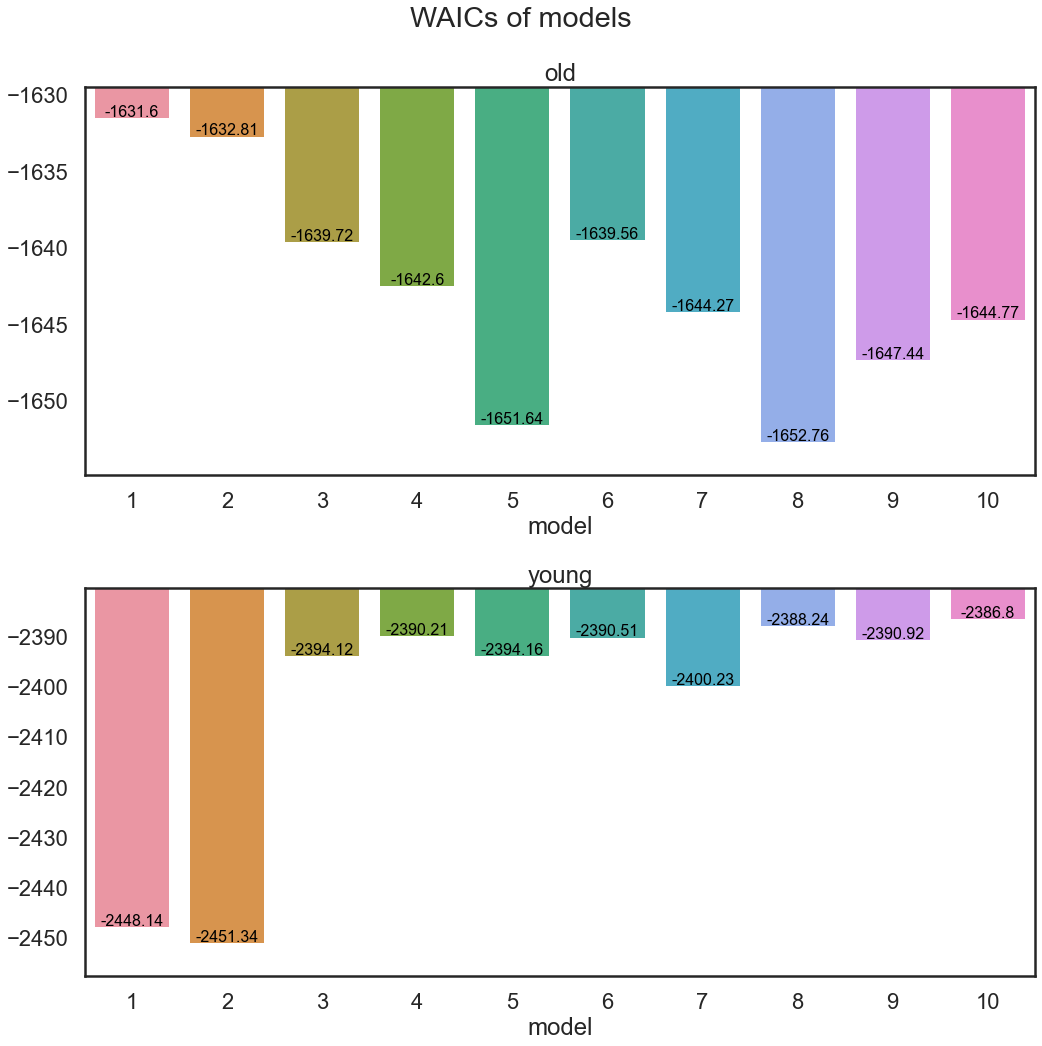

In [106]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
fig.suptitle('WAICs of models')

g1 = sns.barplot(x = list(range(1,11)), y=onp.array(waic_old), ax=ax[0])
g2 = sns.barplot(x = list(range(1,11)), y=onp.array(waic_young), ax=ax[1])

padding_old = 0.1*(max(waic_old) - min(waic_old))
padding_young = 0.1*(max(waic_young) - min(waic_young))

ax[0].set(ylim=(min(waic_old)-padding_old, max(waic_old)+padding_old))
ax[1].set(ylim=(min(waic_young)-padding_young, max(waic_young)+padding_young))
ax[0].set_xlabel('model')
ax[1].set_xlabel('model')
ax[0].set_title('old')
ax[1].set_title('young')

for i in range(len(waic_old)):
    g1.text(i, waic_old[i], round(waic_old[i],2), color='black', ha="center", va ="bottom", size="16")
    g2.text(i, waic_young[i], round(waic_young[i],2), color='black', ha="center", va ="bottom", size="16")
    
plt.tight_layout()

## Simulated behaviour
In what follows we will compare subjects preformance with the performance of simulated agents

In [4]:
import torch

from tasks import SpaceAdventure
from agents import BackInduction
from simulate import Simulator

exp = io.loadmat('../experiment/experimental_variables_new.mat')
starts = exp['startsExp'][:, 0] - 1
planets = exp['planetsExp'] - 1
vect = np.eye(5)[planets]

# setup parameters for the task environment
runs = 50
blocks = 100
na = 2
ns = 6
no = 5

ol1 = torch.from_numpy(vect)
ol2 = torch.from_numpy(np.vstack([vect[50:], vect[:50]]))

starts1 = torch.from_numpy(starts)
starts2 = torch.from_numpy(np.hstack([starts[50:], starts[:50]]))
    
noise = np.tile(np.array([0, 1, 0, 1]), (25,1)).T.flatten()
trials1 = np.tile(np.array([2, 2, 3, 3]), (25,1)).T.flatten()
trials2 = np.tile(np.array([3, 3, 2, 2]), (25,1)).T.flatten()

costs = torch.FloatTensor([-2, -5])  # action costs
fuel = torch.arange(-20., 30., 10.)  # fuel reward of each planet type

confs = torch.stack([ol1, ol2])
confs = confs.view(2, 1, blocks, ns, no).repeat(1, runs//2, 1, 1, 1)\
        .reshape(-1, blocks, ns, no).float()

starts = torch.stack([starts1, starts2])
starts = starts.view(2, 1, blocks).repeat(1, runs//2, 1)\
        .reshape(-1, blocks)
        
conditions = torch.zeros(2, runs, blocks, dtype=torch.long)
conditions[0] = torch.tensor(noise, dtype=torch.long)[None,:]
conditions[1, :runs//2] = torch.tensor(trials1, dtype=torch.long)
conditions[1, runs//2:] = torch.tensor(trials2, dtype=torch.long)

In [16]:
# iterate over different planning depths
agents = []
simulations = []
performance = []
for depth in range(3):
    
    # define space adventure task with aquired configurations
    # set number of trials to the max number of actions
    space_advent = SpaceAdventure(conditions,
                                  outcome_likelihoods=confs,
                                  init_states=starts,
                                  runs=runs,
                                  mini_blocks=blocks,
                                  trials=3)
    
    # define the optimal agent, each with a different maximal planning depth
    agent = BackInduction(confs,
                          runs=runs,
                          mini_blocks=blocks,
                          trials=3,
                          planning_depth=depth+1)
    
    agent.set_parameters()
    
    # simulate experiment
    sim = Simulator(space_advent, 
                    agent, 
                    runs=runs, 
                    mini_blocks=blocks,
                    trials=3)
    sim.simulate_experiment()
    
    simulations.append(sim)
    agents.append(agent)
    
    responses = sim.responses.clone()
    responses[torch.isnan(responses)] = 0
    responses = responses.long()
    
    outcomes = sim.outcomes
    
    points = costs[responses] + fuel[outcomes]
    points[outcomes<0] = 0
    performance.append(points.sum(-1))

In [21]:
sim_data = pd.DataFrame()
rel_score = np.zeros((3, 4))

scores = []
for depth in range(3):
    start_points = 1000
    end_points = start_points + performance[depth].numpy().cumsum(-1)
    points = np.hstack([start_points*np.ones((runs, 1)), end_points])
    df = pd.DataFrame(points.T, columns=range(runs))
    df['mini-block'] = np.arange(blocks + 1)
    df = pd.melt(df, id_vars='mini-block', value_vars=range(runs), value_name='points')
    df['order'] = 1
    df.loc[df.variable >= runs//2, 'order'] = 2
    df['depth'] = depth + 1
    sim_data = sim_data.append(df, ignore_index=True)
    
    phase_values = np.concatenate([start_points*np.ones((runs, 1)), end_points.reshape(-1, 4, 25)[..., -1]], -1)
    diffs = np.diff(phase_values, axis=-1)
                    
    diffs[runs//2:, :] = np.concatenate([diffs[runs//2:, 2:], diffs[runs//2:, :2]], -1)
    scores.append(diffs/25)
    
    rel_score[depth] = diffs.mean(0)/25

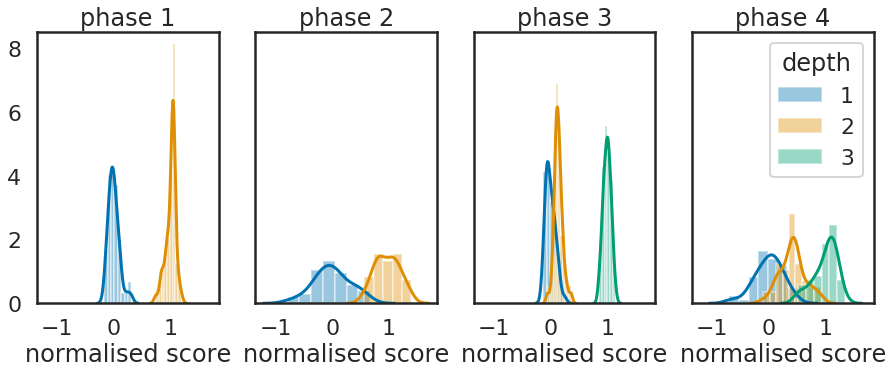

In [22]:
import seaborn as sns
norm_score = np.zeros((3, runs, 4))
for depth in range(3):
    norm_score[depth] = (scores[depth] - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)

for i in range(4):
    axes[i].set_title('phase {}'.format(i + 1))
    axes[i].set_xlabel('normalised score')
    for d in range(3):
        if i < 2:
            if d < 2:
                sns.distplot(norm_score[d, :, i].T, ax=axes[i])
        else:
            sns.distplot(norm_score[d, :, i].T, ax=axes[i])
        
axes[-1].legend([1, 2, 3], title='depth')
fig.savefig('simulates_normalised_scores.pdf', dpi=300)

In [27]:
from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score[-2, :, 0], norm_score[-2, :, 1]))
print(mannwhitneyu(norm_score[-2, :, 0], norm_score[-3, :, 1]))

print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-1, :, 3]))
print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-2, :, 3]))
print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-3, :, 3]))

print(mannwhitneyu(norm_score[-2, :, 0], norm_score[-1, :, 2]))
print(mannwhitneyu(norm_score[-2, :, 1], norm_score[-1, :, 3]))
print(mannwhitneyu(norm_score[-3, :, 1], norm_score[-2, :, 3]))
print(mannwhitneyu(norm_score[-3, :, 1], norm_score[-3, :, 3]))

MannwhitneyuResult(statistic=1112.0, pvalue=0.17144958486644563)
MannwhitneyuResult(statistic=0.0, pvalue=3.3877310522766616e-18)
MannwhitneyuResult(statistic=1022.0, pvalue=0.05838396995437807)
MannwhitneyuResult(statistic=11.0, pvalue=6.787739817928311e-18)
MannwhitneyuResult(statistic=0.0, pvalue=3.5163397301624884e-18)
MannwhitneyuResult(statistic=1037.0, pvalue=0.07134913342665108)
MannwhitneyuResult(statistic=1128.0, pvalue=0.20111100115378755)
MannwhitneyuResult(statistic=365.0, pvalue=5.376184924132812e-10)
MannwhitneyuResult(statistic=1218.0, pvalue=0.4140418721506667)


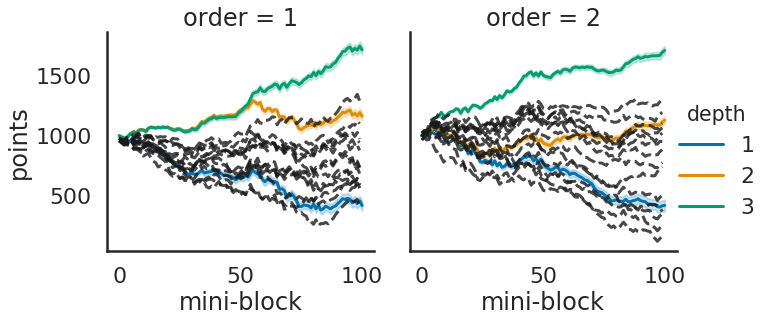

In [28]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "points").add_legend();
mini_blocks = np.arange(1, 101)

for order in range(2):
    for subject in np.unique(data_old.subject.values):
        df = data_old.loc[data_old.order == order+1]
        points = df.loc[df.subject == subject]['end_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

In the above plot we are comparing point counts of individual subjects (dashed black lines) with the mean performance of agents with fixed planning depth. Visual inspection sudjest that in the first group of participants (order = 1) one of the participants eventually behaved as agent of planning depth 3, while the other two are mostly behaving as planning depth 1 agents. In the second group (order = 2) we have one participant which was performing in the range between planning depth 2 and 3 agents and another with low planning depth of 1. Overal, this results suggest that old adults are able to performe the task to certain degree but that we should expect large variability in performance (I would expect in the control group performance variability to be much smaller).

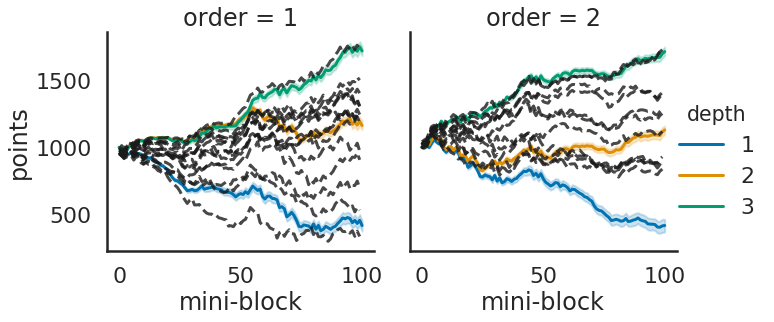

In [29]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "points").add_legend();
mini_blocks = np.arange(1, 101)

for order in range(2):
    for subject in np.unique(data_young.subject.values):
        df = data_young.loc[data_young.order == order+1]
        points = df.loc[df.subject == subject]['end_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

Compared to old adults, in the young adults data set we find larger percentage of participants that used the maximal planning depth throughout the experiment.

MannwhitneyuResult(statistic=342.0, pvalue=0.3517502321879521)
MannwhitneyuResult(statistic=290.0, pvalue=0.1002334187998698)
MannwhitneyuResult(statistic=297.0, pvalue=0.12320803330116897)
MannwhitneyuResult(statistic=353.0, pvalue=0.4245357069698535)


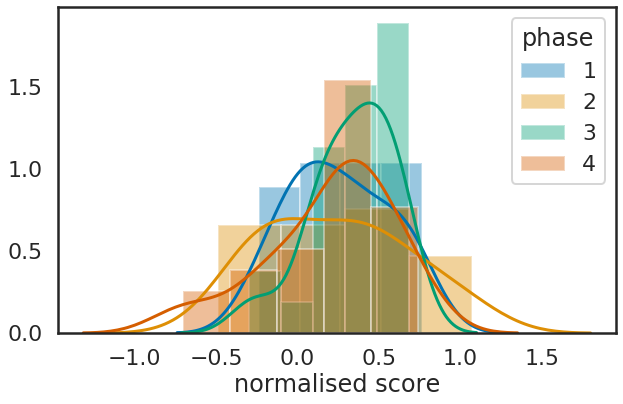

In [30]:
# load planning depth statistics for OA group
pd_stats_oa = np.load('oa_plandepth_stats_B03.npz', allow_pickle=True)
pd_prob_oa = pd_stats_oa['arr_1'][0]  # planning depth probability for the first choice

ep_count_oa = pd_stats_oa['arr_2'][0]  # exc. prob. count for the first choice
ep_prob_oa = ep_count_oa/ep_count_oa.sum(0)
ep_oa = ep_prob_oa.reshape(3, 4, 25, -1).mean(-2)
#######################################################################3

n_subs = pd_prob_oa.shape[1]

score = data_old['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
order = data_old.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

mpd_all_oa = pd_prob_oa.dot(np.arange(1, 4)).reshape(4, 25, -1)
mpd_oa = mpd_all_oa.mean(-2).T
vpd_oa = mpd_all_oa.std(-2).T

mpd_all_oa[..., rev] = np.concatenate([mpd_all_oa[2:, :, rev], mpd_all_oa[:2, :, rev]], 0)
mpd_oa[rev] = np.concatenate([mpd_oa[rev, 2:], mpd_oa[rev, :2]], -1)
vpd_oa[rev] = np.concatenate([vpd_oa[rev, 2:], vpd_oa[rev, :2]], -1)
ep_oa[..., rev] = np.concatenate([ep_oa[:, 2:, rev], ep_oa[:, :2, rev]], -2)

# create data frame with ep and entorpy estimates
data_oa = pd.DataFrame(data=ep_oa[[-2, -2, -1, -1], [0, 1, 2, 3]].T, columns=[1, 2, 3, 4])
data_oa['order'] = order
data_oa = data_oa.melt(id_vars='order', var_name='phase', value_name='EP(depth=max)')
data_oa['group'] = 'OA'

df = pd.DataFrame(data=vpd_oa, columns=[1, 2, 3, 4])
data_oa['std'] = df.melt(var_name='phase', value_name='entropy')['entropy']

score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)
norm_score1 = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

axes.set_xlabel('normalised score')
for i in range(4):
    sns.distplot(norm_score1[:, i], ax=axes)
    
axes.legend([1, 2, 3, 4], title='phase')

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score1[:, 0], norm_score1[:, 1]))
print(mannwhitneyu(norm_score1[:, 2], norm_score1[:, 3]))
print(mannwhitneyu(norm_score1[:, 0], norm_score1[:, 2]))
print(mannwhitneyu(norm_score1[:, 1], norm_score1[:, 3]))

MannwhitneyuResult(statistic=263.0, pvalue=0.17086248206683657)
MannwhitneyuResult(statistic=217.0, pvalue=0.03263828642241747)
MannwhitneyuResult(statistic=266.0, pvalue=0.18604842492052281)
MannwhitneyuResult(statistic=232.0, pvalue=0.060294924946948956)


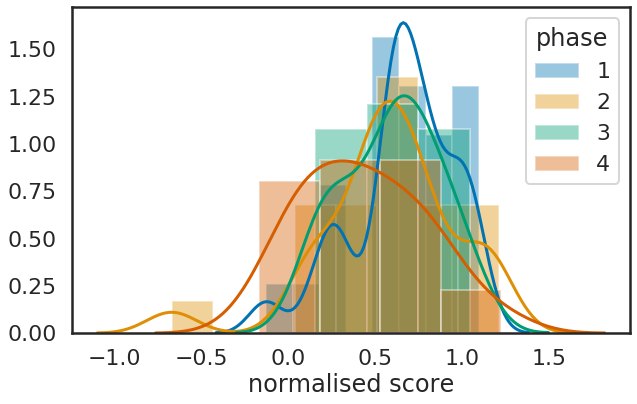

In [31]:
# load planning depth statistics for YA group
pd_stats_ya = np.load('ya_plandepth_stats_B03.npz', allow_pickle=True)
pd_prob_ya = pd_stats_ya['arr_1'][0]  # planning depth probability for the first choice

ep_count_ya = pd_stats_ya['arr_2'][0]  # exc. prob. count for the first choice
ep_prob_ya = ep_count_ya/ep_count_ya.sum(0)
ep_ya = ep_prob_ya.reshape(3, 4, 25, -1).mean(-2)
####################################################################################

n_subs = pd_prob_ya.shape[1]

mpd_all_ya = pd_prob_ya.dot(np.arange(1, 4)).reshape(4, 25, -1)
mpd_ya = mpd_all_ya.mean(-2).T
vpd_ya = mpd_all_ya.std(-2).T

order = data_young.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

mpd_all_ya[..., rev] = np.concatenate([mpd_all_ya[2:, :, rev], mpd_all_ya[:2, :, rev]], 0)
mpd_ya[rev] = np.concatenate([mpd_ya[rev, 2:], mpd_ya[rev, :2]], -1)
vpd_ya[rev] = np.concatenate([vpd_ya[rev, 2:], vpd_ya[rev, :2]], -1)
ep_ya[..., rev] = np.concatenate([ep_ya[:, 2:, rev], ep_ya[:, :2, rev]], -2)

data_ya = pd.DataFrame(data=ep_ya[[-2, -2, -1, -1], [0, 1, 2, 3]].T, columns=[1, 2, 3, 4])
data_ya['order'] = order
data_ya = data_ya.melt(id_vars='order', var_name='phase', value_name='EP(depth=max)')
data_ya['group'] = 'YA'

df = pd.DataFrame(data=vpd_ya, columns=[1, 2, 3, 4])
data_ya['std'] = df.melt(var_name='phase', value_name='entropy')['entropy']

score = data_young['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)
norm_score2 = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
axes.set_xlabel('normalised score')
for i in range(4):
    sns.distplot(norm_score2[:, i], ax=axes)
    
axes.legend([1, 2, 3, 4], title='phase')

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score2[:, 0], norm_score2[:, 1]))
print(mannwhitneyu(norm_score2[:, 2], norm_score2[:, 3]))
print(mannwhitneyu(norm_score2[:, 0], norm_score2[:, 2]))
print(mannwhitneyu(norm_score2[:, 1], norm_score2[:, 3]))

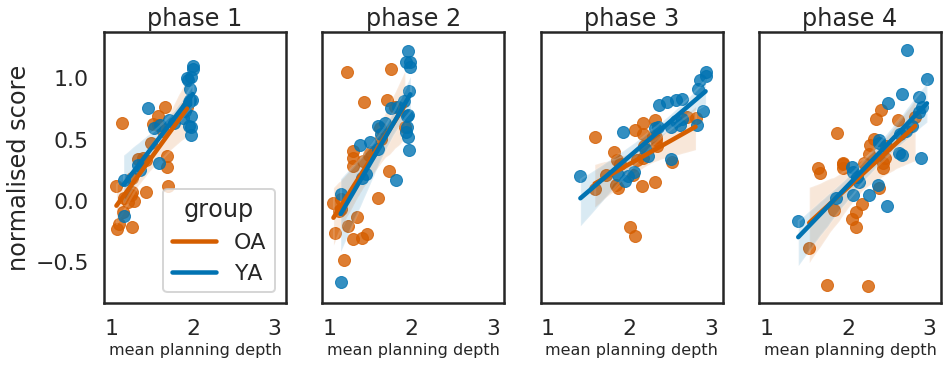

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True, sharex=True)

mpd = [mpd_oa, mpd_ya]
ns = [norm_score1, norm_score2]
color = ['r', 'b'] 
for j in range(2):
    for i in range(4):
        sns.regplot(mpd[j][:, i], ns[j][:, i], ax=axes[i], color=color[j])
        axes[i].set_title('phase {}'.format(i+1));
        axes[i].set_xlabel('mean planning depth', fontsize=16);
    
axes[0].set_ylabel('normalised score');
axes[0].legend(['OA', 'YA'], title='group')

fig.savefig('score_vs_depth_B03.pdf', dpi=300)    

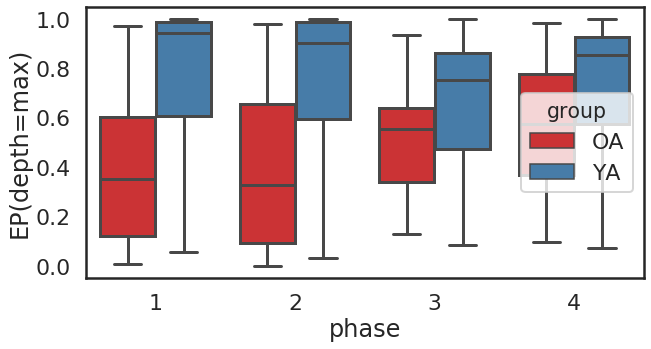

In [63]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot('phase', 'EP(depth=max)', data=data, hue='group', ax=ax, palette='Set1')

fig.savefig('ep_dist_B03.pdf', dpi=300)

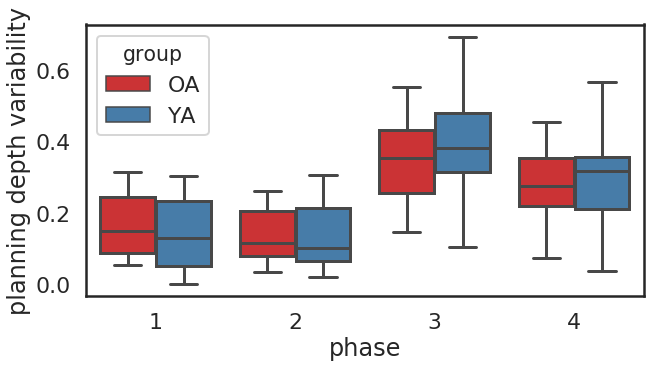

In [138]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot('phase', 'std', data=data, hue='group', ax=ax, palette='Set1')
ax.set_ylabel('planning depth variability')

fig.savefig('variability_dist_B03.pdf', dpi=300)

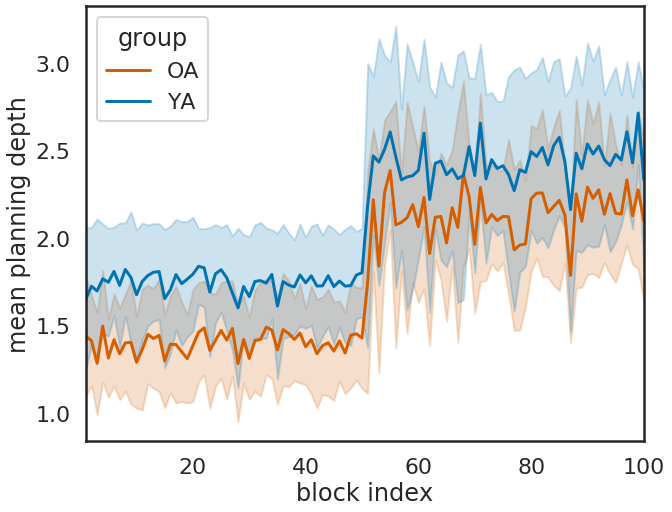

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

df1 = pd.DataFrame(mpd_all_oa.reshape(blocks, -1))
df1['block_index'] = np.arange(1, blocks+1)
df1 = df1.melt(id_vars=['block_index'], var_name='subject')

df2 = pd.DataFrame(mpd_all_ya.reshape(blocks, -1))
df2['block_index'] = np.arange(1, blocks+1)
df2 = df2.melt(id_vars=['block_index'], var_name='subject')

sns.lineplot(x='block_index', y='value', data=df1, color='r', ci='sd', label='OA');
sns.lineplot(x='block_index', y='value', data=df2, color='b', ci='sd', label='YA');

ax.set_ylabel('mean planning depth');
ax.set_xlabel('block index');
ax.legend(title='group', loc=2);
ax.set_xlim([1, 100]);

fig.savefig('build3_b03.png', dpi=600)
fig.savefig('build3_b03.svg', dpi=300)


In [113]:
n_sub_oa = mpd_oa.shape[0]
n_sub_ya = mpd_ya.shape[0]

ids = [data_old['ID'].values.reshape(n_sub_oa, -1)[:, 0],
       data_young['ID'].values.reshape(n_sub_ya, -1)[:, 0]]
gl = ['OA', 'YA']
mpd = [mpd_oa, mpd_ya]
ns = [norm_score1, norm_score2]
vpd = [vpd_oa, vpd_ya]
ep = [ep_oa[[-2, -2, -1, -1], [0, 1, 2, 3]], ep_ya[[-2, -2, -1, -1], [0, 1, 2, 3]]]

results = pd.DataFrame()
for g in range(2):
    for phase in range(4):
        df = pd.DataFrame({'PD': mpd[g][:, phase], 
                           'NS': ns[g][:, phase],
                           'STD': vpd[g][:, phase],
                           'EP(depth=max)': ep[g][phase],
                           'subject': np.arange(1, ns[g].shape[0] +1),
                           'ID': ids[g],
                           'phase': phase + 1,
                           'group': gl[g]})
        
        results = results.append(df, ignore_index=True)
        
results.to_csv('NS_PD_Entropy_B03.csv')

MannwhitneyuResult(statistic=2576.0, pvalue=3.752240703815699e-11)

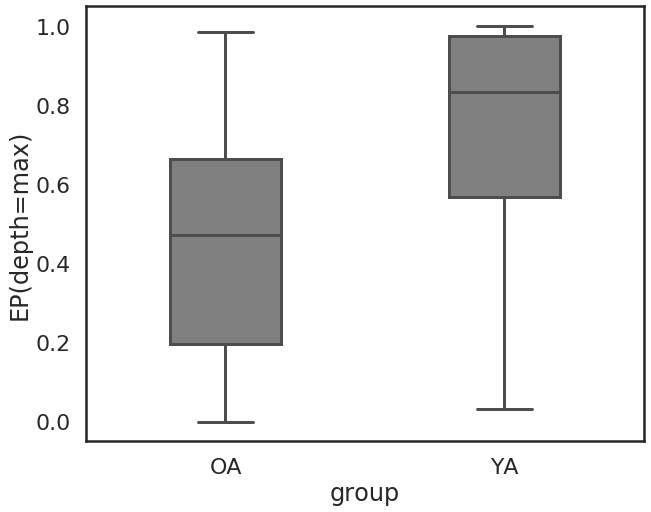

In [87]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot('group', 'EP(depth=max)', data=results, ax=ax, color='gray', width=0.4)

fig.savefig('bild2_B03.eps', dpi=300)
fig.savefig('bild2_B03.png', dpi=600)

mannwhitneyu(results.loc[results.group == 'OA', 'EP(depth=max)'], results.loc[results.group == 'YA', 'EP(depth=max)'])

MannwhitneyuResult(statistic=5315.0, pvalue=0.4227618798022342)

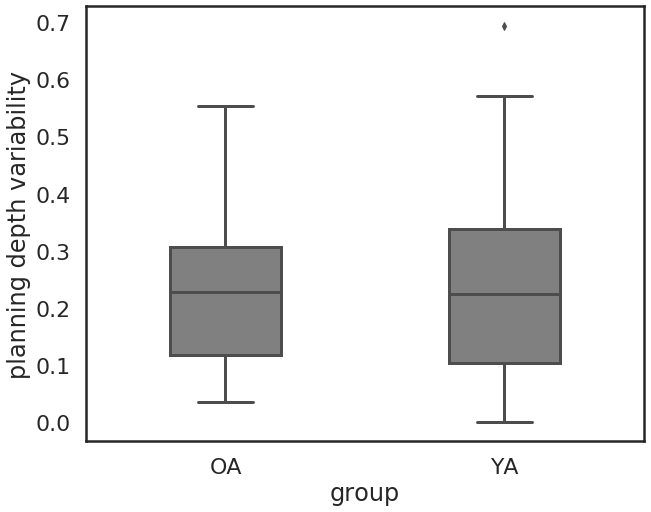

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='group', y='STD', data=results, color='gray', width=0.4)

ax.set_ylabel('planning depth variability')

fig.savefig('planning_depth_variability_B03.eps', dpi=300)
fig.savefig('planning_depth_variability_B03.png', dpi=600)

mannwhitneyu(results.loc[results.group == 'OA', 'STD'], results.loc[results.group == 'YA', 'STD'])

MannwhitneyuResult(statistic=3430.0, pvalue=2.7980015114332186e-06)

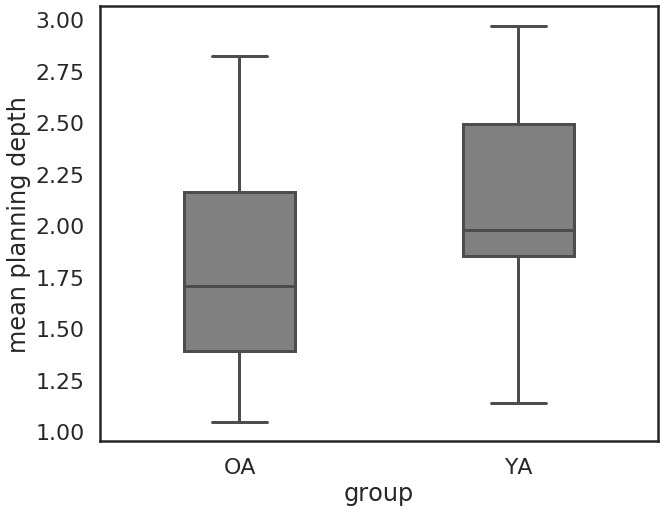

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='group', y='PD', data=results, color='gray', width=0.4)

ax.set_ylabel('mean planning depth')


fig.savefig('bild1_B03.eps', dpi=300)
fig.savefig('bild1_B03.png', dpi=600)
mannwhitneyu(results.loc[results.group == 'OA', 'PD'], results.loc[results.group == 'YA', 'PD'])